In [1]:
import numpy as np
import pandas as pd
from spykes.plot.neurovis import NeuroVis
from spykes.plot.popvis import PopVis
import matplotlib.pyplot as plt
import fklab.signals.multitaper as mt
import scipy.signal
import fklab.signals.filter

%matplotlib notebook

plt.style.use('seaborn-ticks')


from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import itertools

from fklab.io.data import import_position
from fklab.io.data import import_environment
import fklab.geometry.utilities
import fklab.segments as segments
from fklab.segments import Segment

from fklab.signals.smooth import kernelsmoothing
from fklab.behavior import task_analysis

from data_analysis import loading

loading.load_project('/media/kasia/K/Neuropixeldata/LS_k_5/catgt_14032020-b0_g0')
# loading.load_lfp('12032020_g0_t0.imec0.lf.bin')

In [2]:
loading.load_cluster()
ls_data = loading.cluster_data
loading.load_position('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/epochs/training/position.hdf5')
loading.load_position_yaml()
loading.load_environment_yaml()
loading.load_kilosort()
loading.load_event('/media/kasia/K/Neuropixeldata/LS_k_5/2020-03-14_13-02-19/Events.nev',)

In [3]:
time_shift = -5
Fs=3000

In [4]:
position_time = np.array(loading.position_time)
corrected_time = position_time + time_shift
corrected_time

array([2326.004069, 2326.044189, 2326.083729, ..., 5281.618655,
       5281.658753, 5281.699314])

In [5]:
#loading spiking data
project_root = '/media/kasia/K/Neuropixeldata/LS_k_5/catgt_14032020-b0_g0/'

clusters = np.load(project_root + "spike_clusters.npy")
# print(clusters)
spike_times = np.load(project_root + "spike_times.npy") / Fs
#print(spike_times)
spike_templates = np.load(project_root + "templates.npy")

y_coords = np.load(project_root + "channel_positions.npy")
#print(y_coords)
spike_clusters = np.load(project_root + "spike_clusters.npy")

In [6]:
#loading clusters 
dtype = np.dtype([
    ('id', np.int),
    ('Amplitude', np.float),
    ('ContamPct', np.float),
    ('KSLabel', np.dtype('U5')),
    ('amp', np.float),
    ('channel', np.int),
    ('depth', np.float),
    ('firing_rate', np.float),
    ('group', np.dtype('U5')),
    ('n_spikes', np.int),
    ('shank', np.int),
])

data = np.loadtxt(project_root + "cluster_info.tsv",
                 dtype=dtype, skiprows=1, delimiter='\t',
                 converters={7:lambda fr: fr.replace(b' spk/s', b'')})
# print(data)
# print(data['channel'])
#print(data[data['KSLabel'] == 'good'])
data_good = data[data['KSLabel']== 'good']
# data_good = data[data['group'] == 'good']
# print(len(all_data_good))
# print(spike_times)

In [7]:
depth = data_good['depth']
n_spk = data_good['n_spikes']
id_s = data_good['id']
channel= data_good['channel']

In [8]:
epoch = loading.position_yaml['source']['epoch']
epoch
open_field_epoch = [2331, 3515]
Y_maze_epoch = [3533, 5230]

In [9]:
from fklab.geometry.shapes import rectangle
open_field_data = loading.environment_yaml['open_field']['shapes']['open_field']['shape']
open_field = rectangle(**open_field_data)
open_field

rectangle (size=[68.08695652173911,74.19130434782609], center=[103.77391304347829,44.84347826086957], orientation=0.0 rad)

In [10]:
# print(loading.environment_yaml)

In [11]:
from fklab.geometry.shapes import graph, polyline
Y_maze_data = loading.environment_yaml['AT']['shapes']['AT']['shape']
Y_maze_data['polylines'] = [polyline(**p) if not isinstance(p, polyline) else p for p in Y_maze_data['polylines']]
Y_maze = graph(**Y_maze_data)
# print(Y_maze)
left_arm_d = loading.environment_yaml['AT']['shapes']['left_arm']['shape']
left_arm = polyline(**left_arm_d)
# left_arm
right_arm_d = loading.environment_yaml['AT']['shapes']['left_arm']['shape']
right_arm = polyline(**right_arm_d)
right_arm




straight polyline with 2 vertices

[[ 92.61        14.85      ]
 [ 92.67707208  15.15182438]
 [ 92.74482274  15.45670234]
 ...
 [127.98        29.43      ]
 [127.44        29.97      ]
 [127.17        28.89      ]]


<IPython.core.display.Javascript object>


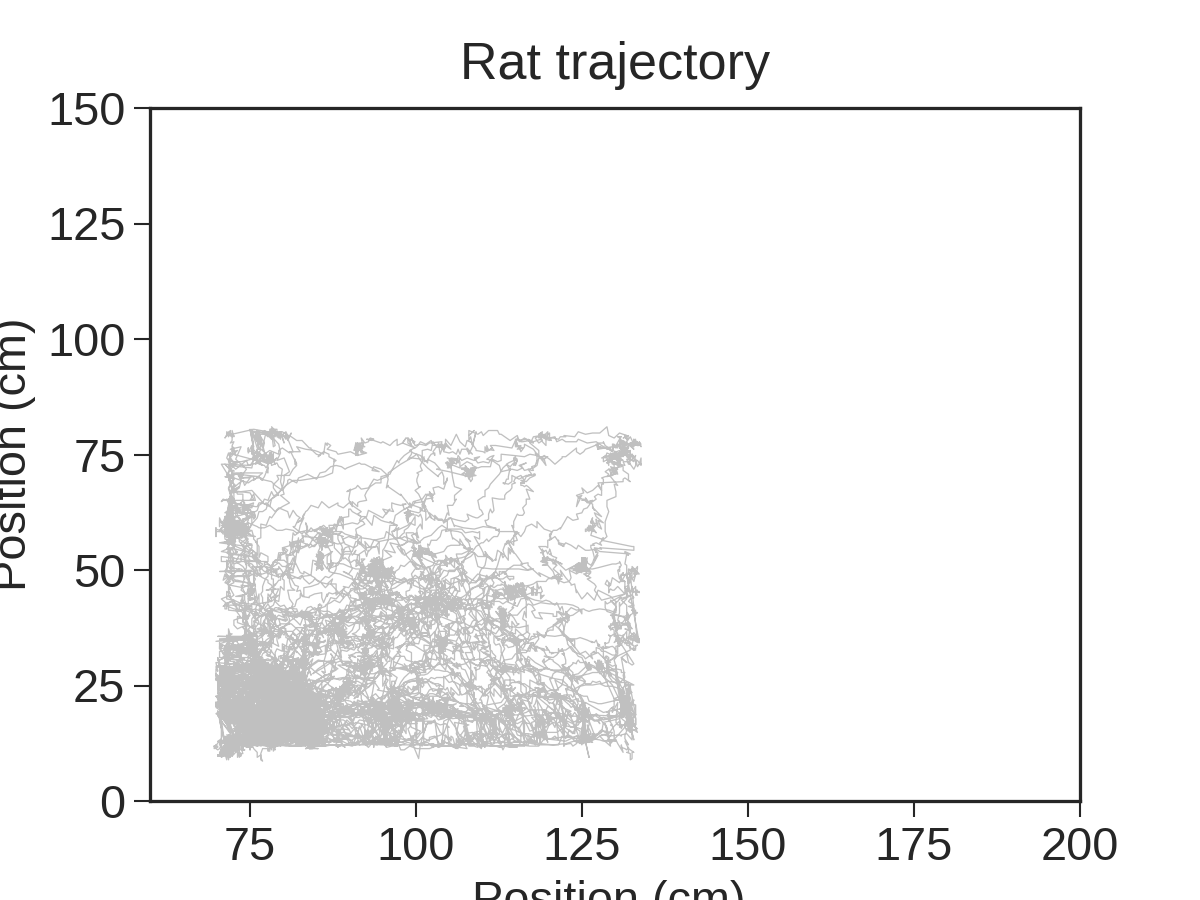

In [17]:
position_ob = loading.position[np.logical_and(corrected_time > open_field_epoch[0],
                                      corrected_time < open_field_epoch[1]), :]
position_ob_cm = position_ob * 0.27
print(position_ob_cm)
plt.plot(position_ob_cm[:, 0], position_ob_cm[:, 1], color='silver', lw=0.5)
plt.xlim(60, 200)
plt.ylim(0,150)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Rat trajectory", y=1.02)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.savefig("rat_trajectory (open field)LS_5_140320.png")

<IPython.core.display.Javascript object>


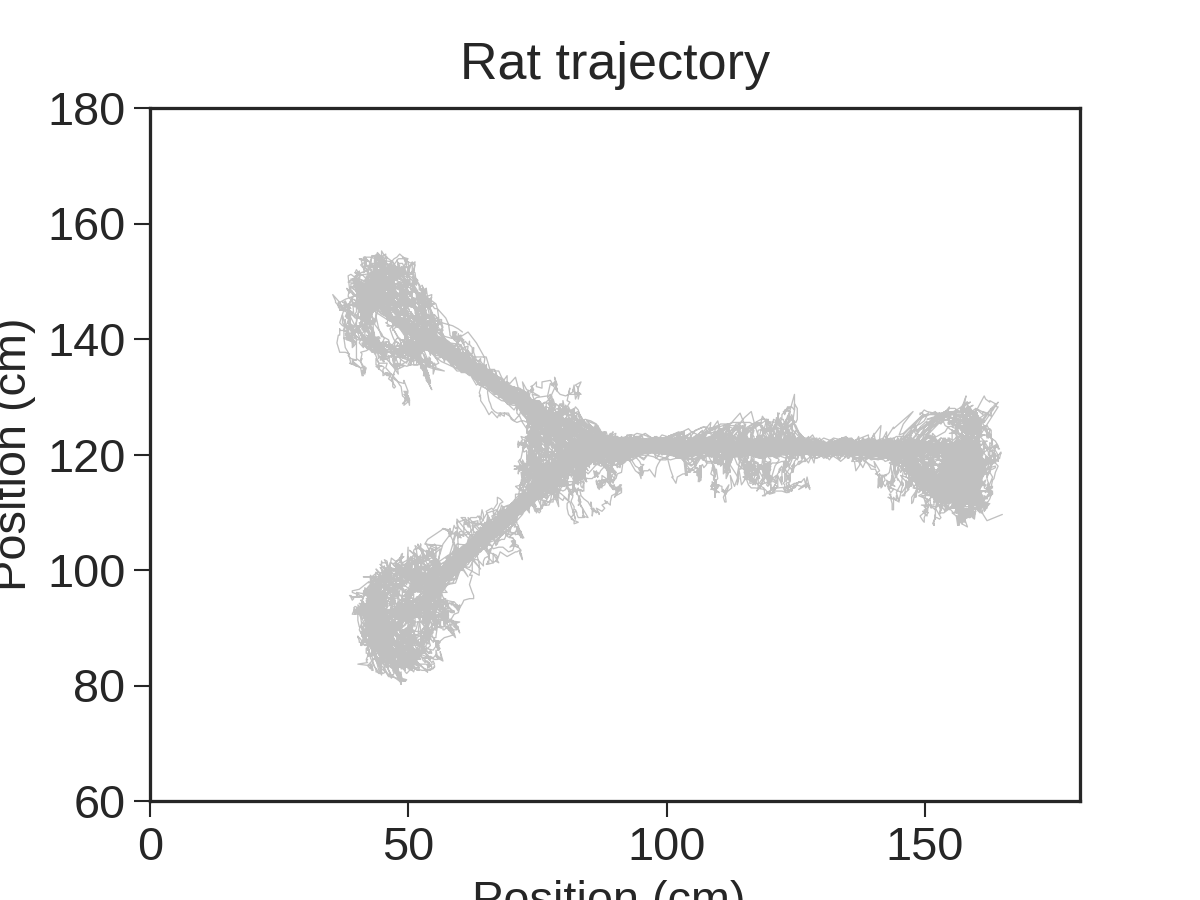

In [18]:
position_at = loading.position[np.logical_and(corrected_time > Y_maze_epoch[0],
                                      corrected_time < Y_maze_epoch[1]), :]
position_at_cm = position_at * 0.27

plt.plot(position_at_cm[:, 0], position_at_cm[:, 1], color='silver', lw=0.5)
plt.xlim(0, 180)
plt.ylim(60, 180)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Rat trajectory", y=1.02)
plt.rc('axes', labelsize=MEDIUM_SIZE)
# plt.savefig("rat_trajectory (Y_maze)LS_5_140320.png")

In [13]:
print(min(position_ob_cm[:,0]))
print(min(position_ob_cm[:,1]))
print(max(position_ob_cm[:,0]))
print(max(position_ob_cm[:,1]))

NameError: name 'position_ob_cm' is not defined

15246


<IPython.core.display.Javascript object>


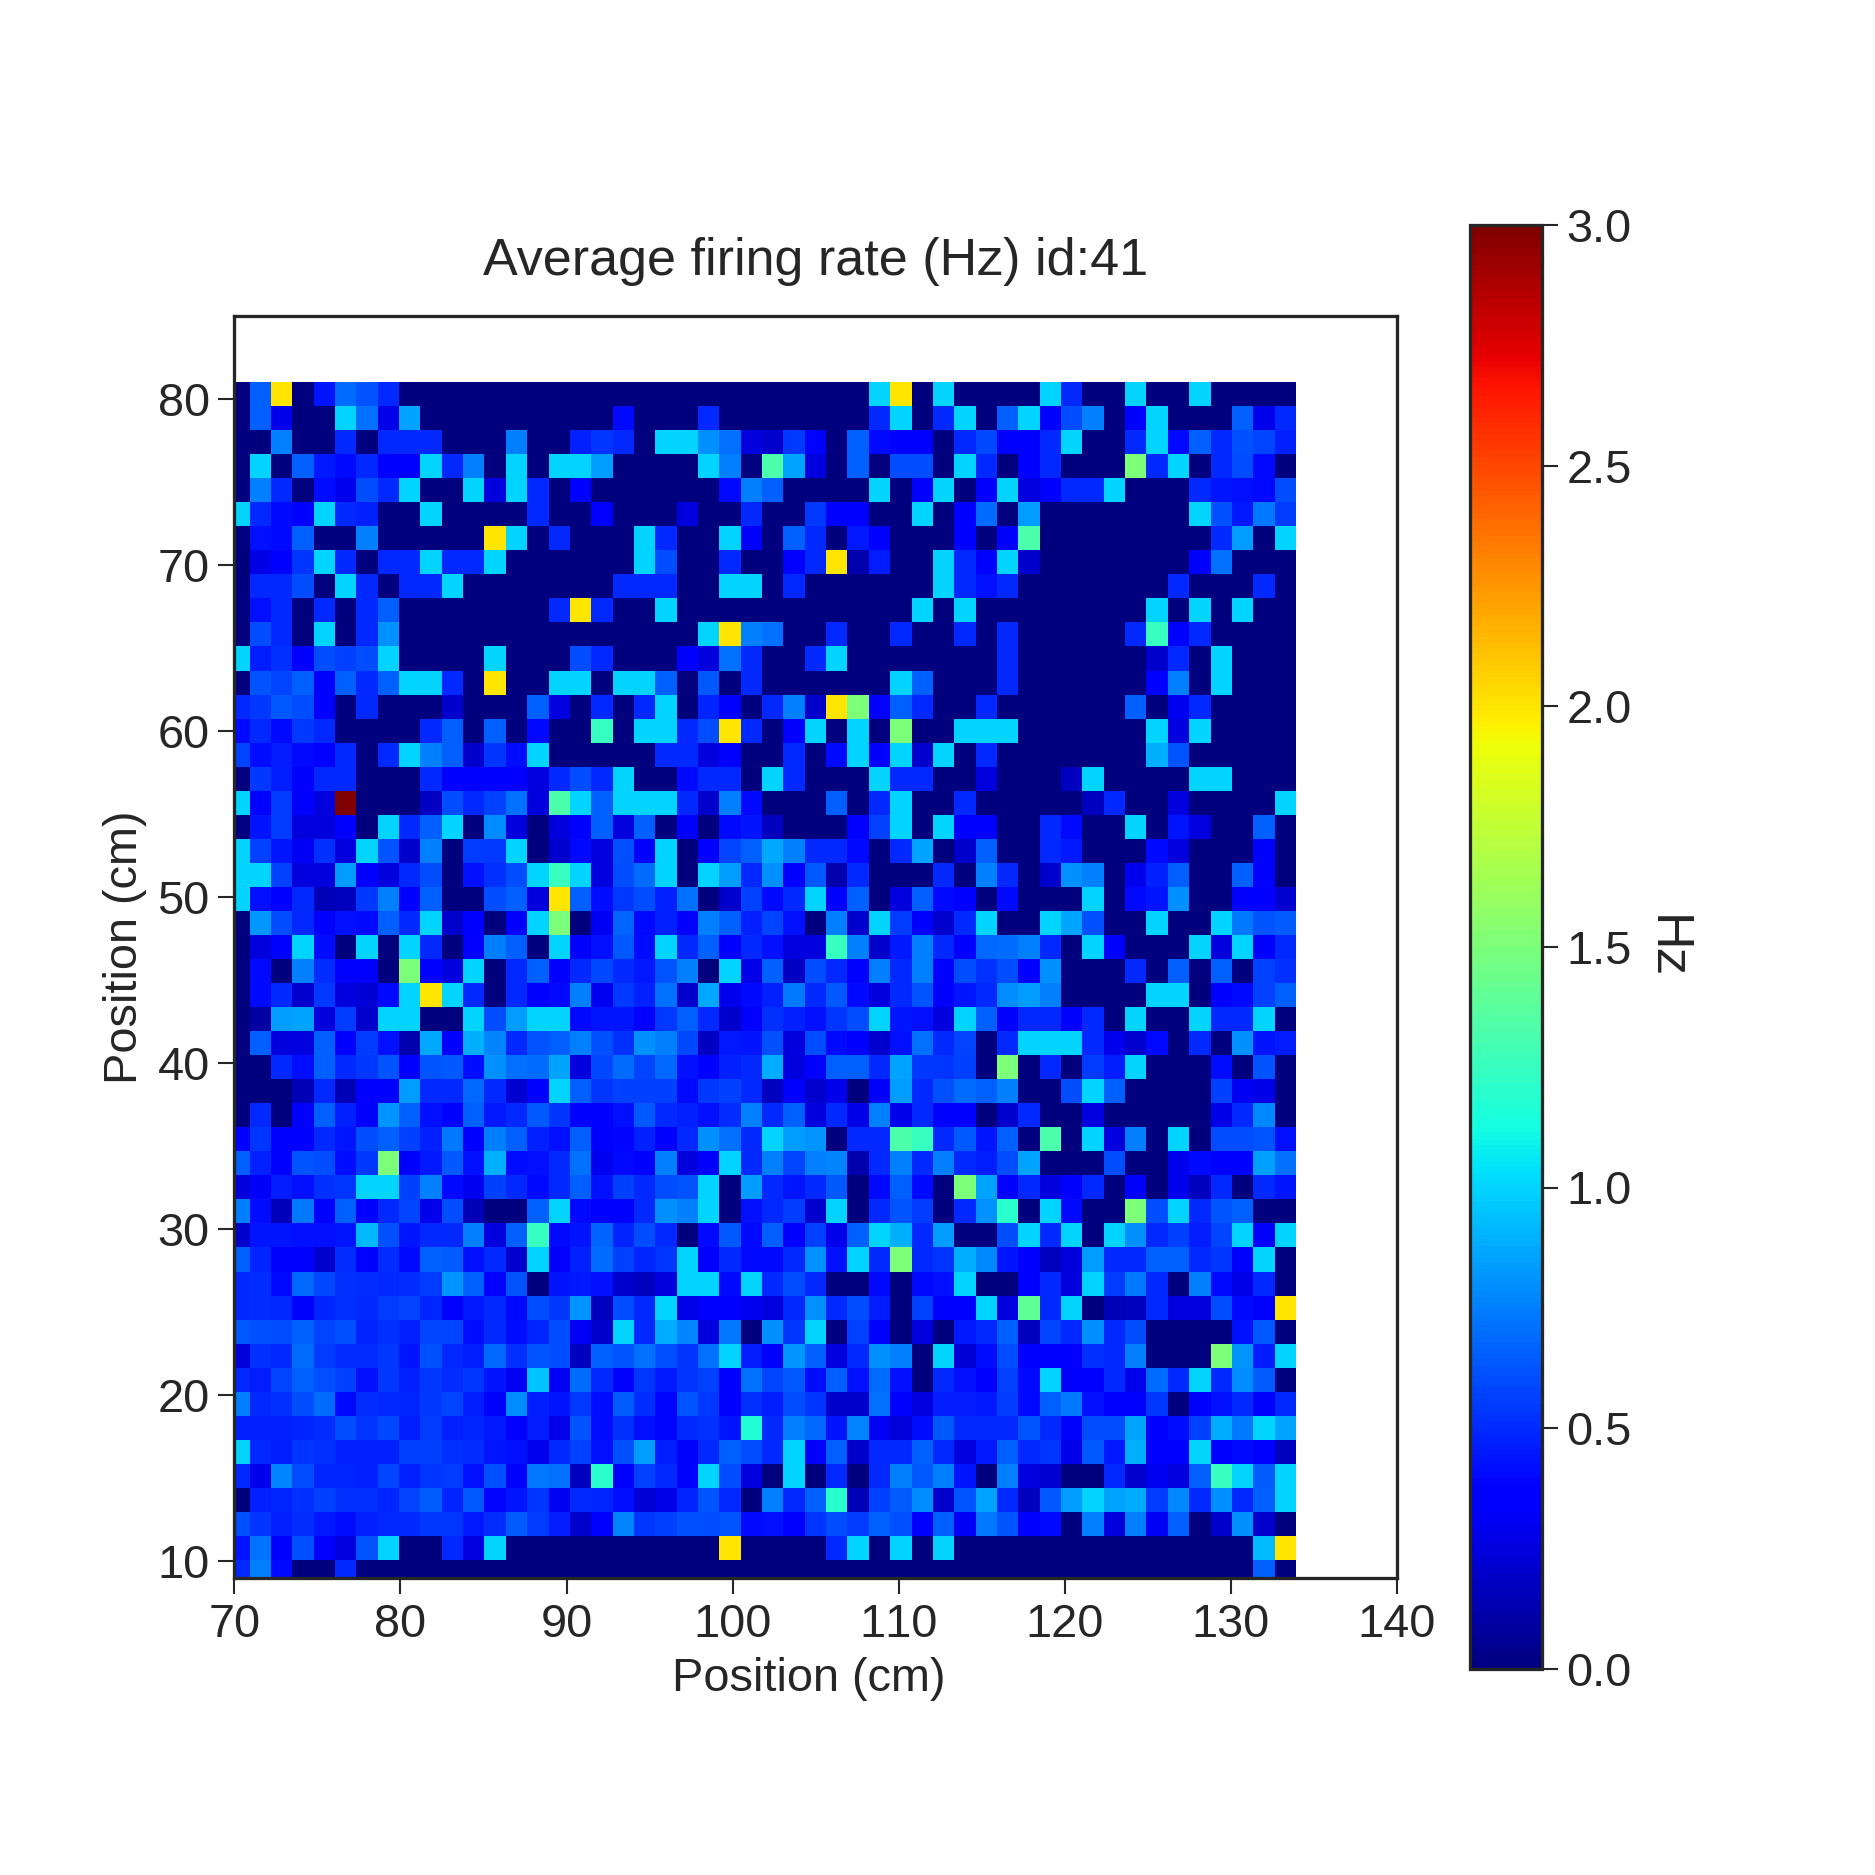

In [19]:
#open box
spike_t = []
spike_time_range = np.array(open_field_epoch) - open_field_epoch[0] + time_shift
# print(spike_time_range)
picked_channel = [103]
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(data_good['id']):
#     print('cluster_id', cluster_id)
    if data_good['channel'][cluster_index] not in picked_channel:
        continue
        
    spike_ts = loading.ks_spike_times[np.logical_and.reduce((
        loading.ks_spike_clusters == cluster_id,
        spike_time_range[0] <= loading.ks_spike_times[:, 0],
        loading.ks_spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t.extend(spike_ts)

    
print(len(spike_t))


x = position_ob_cm[:, 0]
y = position_ob_cm[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

spike_times_binned = scipy.stats.binned_statistic(spike_t, 
                                                  np.ones_like(spike_t) / len(picked_channel), 
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

spike_bin = scipy.stats.binned_statistic_2d(y[mask], 
                                            x[mask], 
                                            spike_times_binned[mask], 
                                            statistic='mean', 
                                            bins=50)[0]

spike_bin[np.isnan(spike_bin)] = 0.0
spike_bin[np.isinf(spike_bin)] = 0.0

# print(spike_bin.min(), spike_bin.max())

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel( bandwidth = np.array([3,3]) )
S = smooth.Smoother(K, unbiased=True)
spike_bin_smoothed = S(spike_bin)
extent = (
    np.min(x[mask]), np.max(x[mask]),
    np.min(y[mask]), np.max(y[mask])
)


plt.imshow(spike_bin, cmap='jet', origin='lower', extent=extent)
plt.xlim(70, 140)
plt.ylim(9, 85)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Average firing rate (Hz) id:41", y=1.02)
# plt.legend(bbox_to_anchor=(0.97, 0.9), markerscale=3, handletextpad=0.1, title=' neuronID')
plt.rc('axes', labelsize=MEDIUM_SIZE)
# plt.savefig("firing_rate(open field)41.png")
plt.show()

<IPython.core.display.Javascript object>


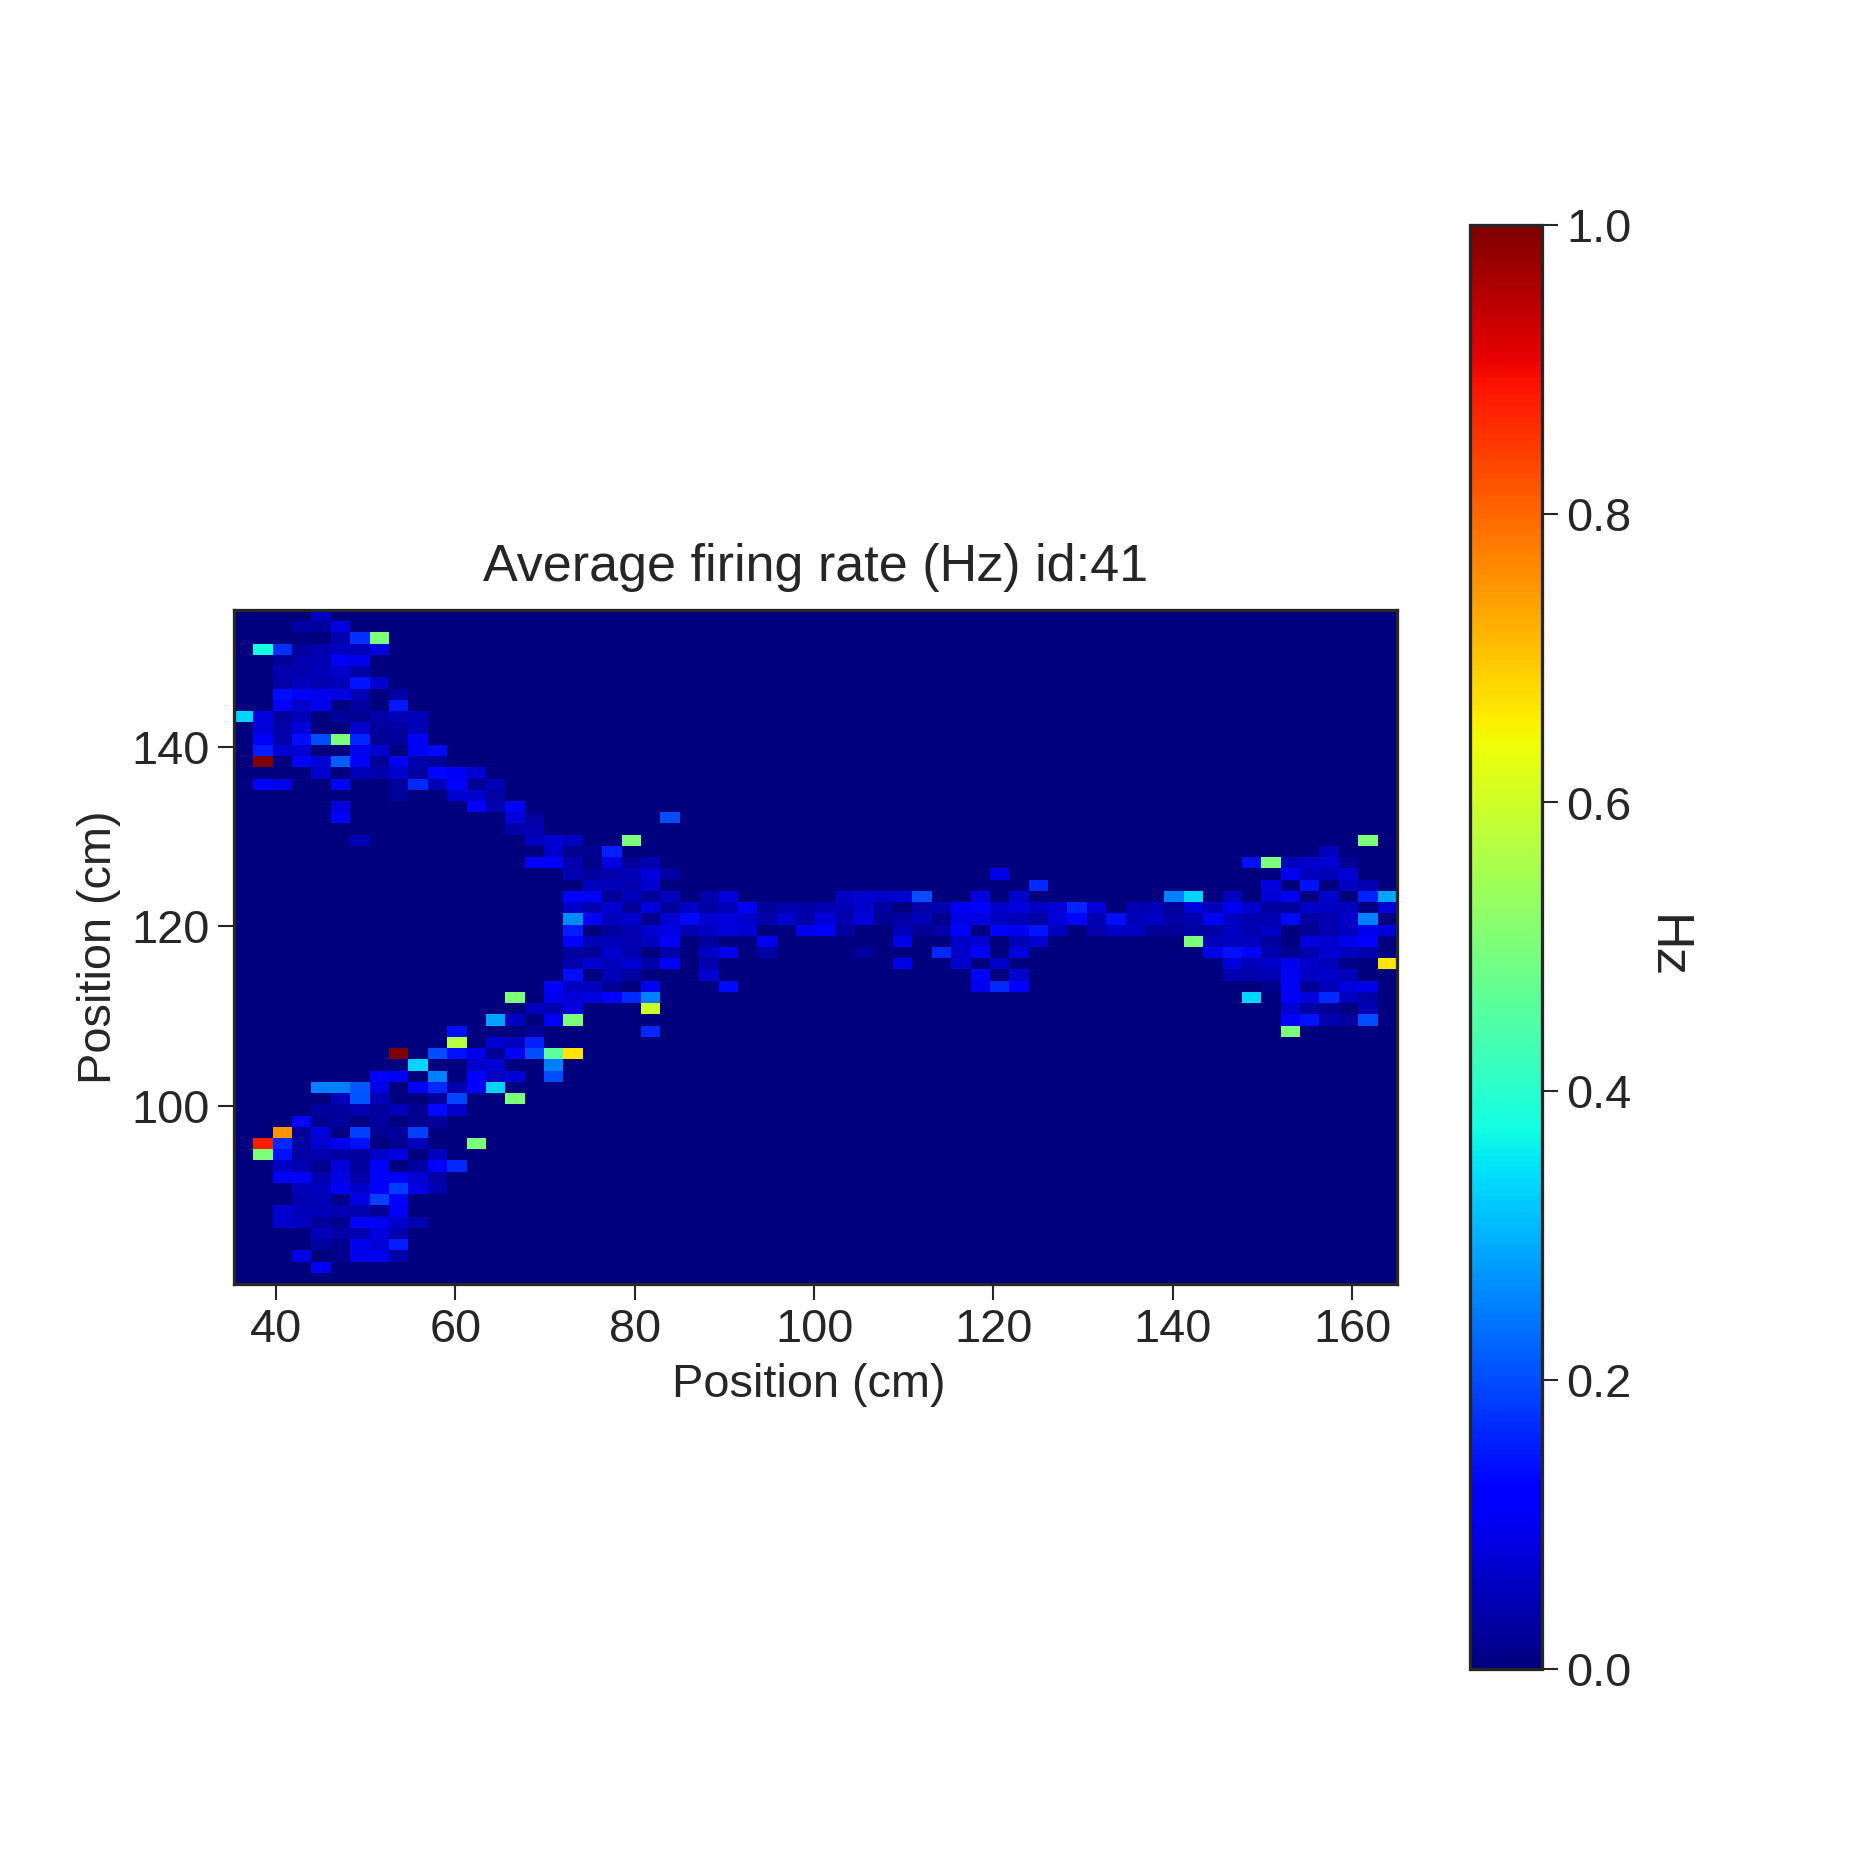

In [20]:
spike_t = []
spike_time_range = np.array(Y_maze_epoch) - Y_maze_epoch[0] + time_shift
# print(spike_time_range)
picked_channel = [301]
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(data_good['id']):
#     print('cluster_id', cluster_id)
    if data_good['channel'][cluster_index] not in picked_channel:
        continue
        
    spike_ts = loading.ks_spike_times[np.logical_and.reduce((
        loading.ks_spike_clusters == cluster_id,
        spike_time_range[0] <= loading.ks_spike_times[:, 0],
        loading.ks_spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t.extend(spike_ts)

    
# print(len(spike_t))


x = position_at_cm[:, 0]
y = position_at_cm[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))

spike_times_binned = scipy.stats.binned_statistic(spike_t, 
                                                  np.ones_like(spike_t) / len(picked_channel), 
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

spike_bin = scipy.stats.binned_statistic_2d(y[mask], 
                                            x[mask], 
                                            spike_times_binned[mask], 
                                            statistic='mean', 
                                            bins=60)[0]

spike_bin[np.isnan(spike_bin)] = 0.0
spike_bin[np.isinf(spike_bin)] = 0.0

# print(spike_bin.min(), spike_bin.max())

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel( bandwidth = np.array([1,1]) )
S = smooth.Smoother(K, unbiased=True)
spike_bin_smoothed = S(spike_bin)
extent = (
    np.min(x[mask]), np.max(x[mask]),
    np.min(y[mask]), np.max(y[mask])
)


plt.imshow(spike_bin, cmap='jet', origin='lower', extent=extent)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Average firing rate (Hz) id:41", y=1.02)
# plt.legend(bbox_to_anchor=(0.97, 0.9), markerscale=3, handletextpad=0.1, title=' neuronID')
plt.rc('axes', labelsize=MEDIUM_SIZE)
# plt.savefig("firing_rate(open field)41.png")
plt.show()

   t_ob.min, max= 2331.0043809999997 3514.995537


<IPython.core.display.Javascript object>


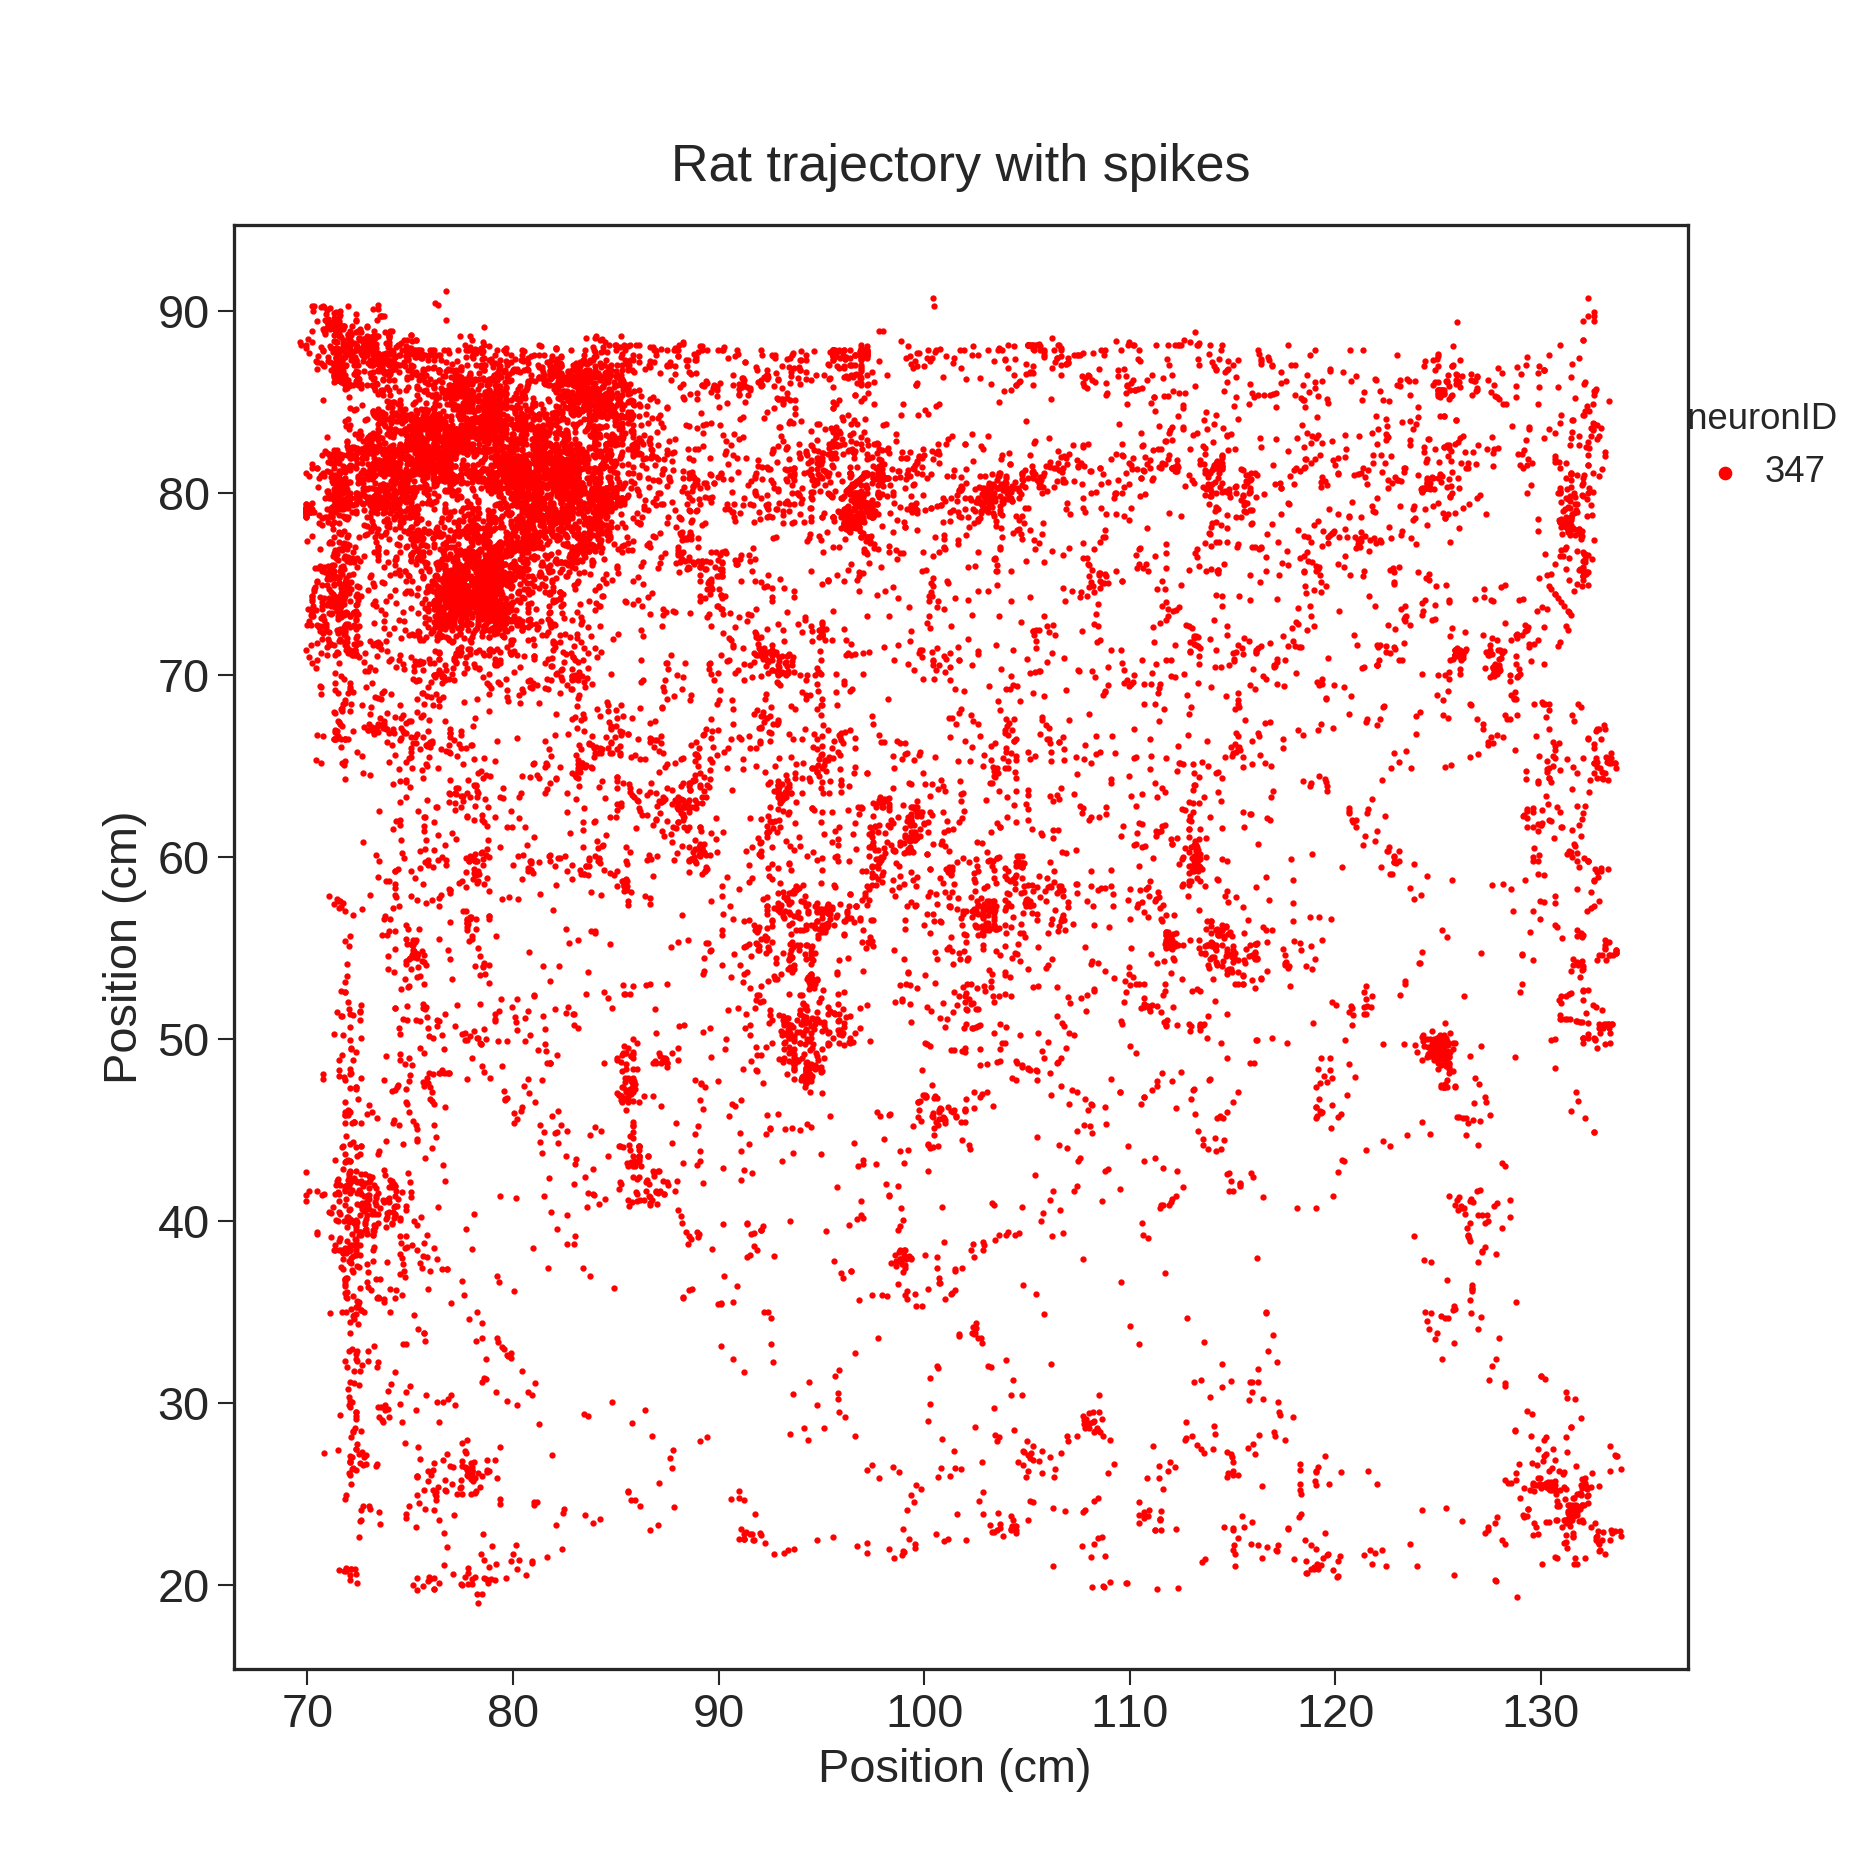

In [21]:
from scipy.interpolate import interp1d

spike_time_range_at = np.array(open_field_epoch) - loading.evt_start_time[1] + time_shift

plt.rcParams["figure.figsize"] = (10,10)

ks_spike_times = loading.ks_spike_times[:, 0] 
spike_t_347 = ks_spike_times[loading.get_spike_seq(spike_time_range, channel_list=[103])] + loading.evt_start_time[1]
# # spike_t_41 = ks_spike_times[loading.get_spike_seq(spike_time_range, channel_list=[41])]  + loading.evt_start_time
# print(spike_t_347)
# print('len(spike_t)=', len(spike_t))
# print('spike_t.min, max=', spike_t.min(0), spike_t.max(0))


t_of = corrected_time[np.logical_and(corrected_time > open_field_epoch[0], corrected_time < open_field_epoch[1])]
# t_lt = corrected_time[np.logical_and(corrected_time > linear_track_epoch[0], corrected_time < linear_track_epoch[1])]
mask = ~np.logical_or.reduce((
    np.isnan(t_of),
    np.isnan(position_ob_cm[:, 0]),
    np.isnan(position_ob_cm[:, 1]),
))
# mask = ~np.logical_or.reduce((
#     np.isnan(t_lt),
#     np.isnan(position_lt_cm[:, 0]),
#     np.isnan(position_lt_cm[:, 1]),
# ))

print('   t_ob.min, max=', t_of[mask].min(), t_of[mask].max())
# plt.plot(position_ob_cm[mask, 0], 100 - position_ob_cm[mask, 1], color="silver", alpha=0.3)
# plt.plot(position_lt_cm[mask, 0], position_lt_cm[mask, 1], color="silver", alpha=0.3)

interp1d_of = interp1d(t_of[mask], position_ob_cm[mask, :],
                      axis=0, 
#                     fill_value='extrapolate', 
                    bounds_error=False,
                    assume_sorted=True)
# interp1d_od = interp1d(t_lt[mask], position_lt_cm[mask, :],
#                       axis=0, 
# #                     fill_value='extrapolate', 
#                     bounds_error=False,
#                     assume_sorted=True)


spike_xy_347 = interp1d_of(spike_t_347)
# spike_xy_41 = interp1d_od(spike_t_41)


plt.scatter(spike_xy_347[:, 0], 100 - spike_xy_347[:, 1], s=2, color='r', label='347')
# plt.scatter(spike_xy_41[:, 0], 100 - spike_xy_41[:, 1], s=2, color='g', label='41')

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Rat trajectory with spikes", y=1.02)
plt.legend(bbox_to_anchor=(0.97, 0.9), markerscale=3, handletextpad=0.1, title=' neuronID')
plt.rc('axes', labelsize=MEDIUM_SIZE)
# plt.savefig("rat_trajectory (open field)41.png")

plt.show()

<IPython.core.display.Javascript object>


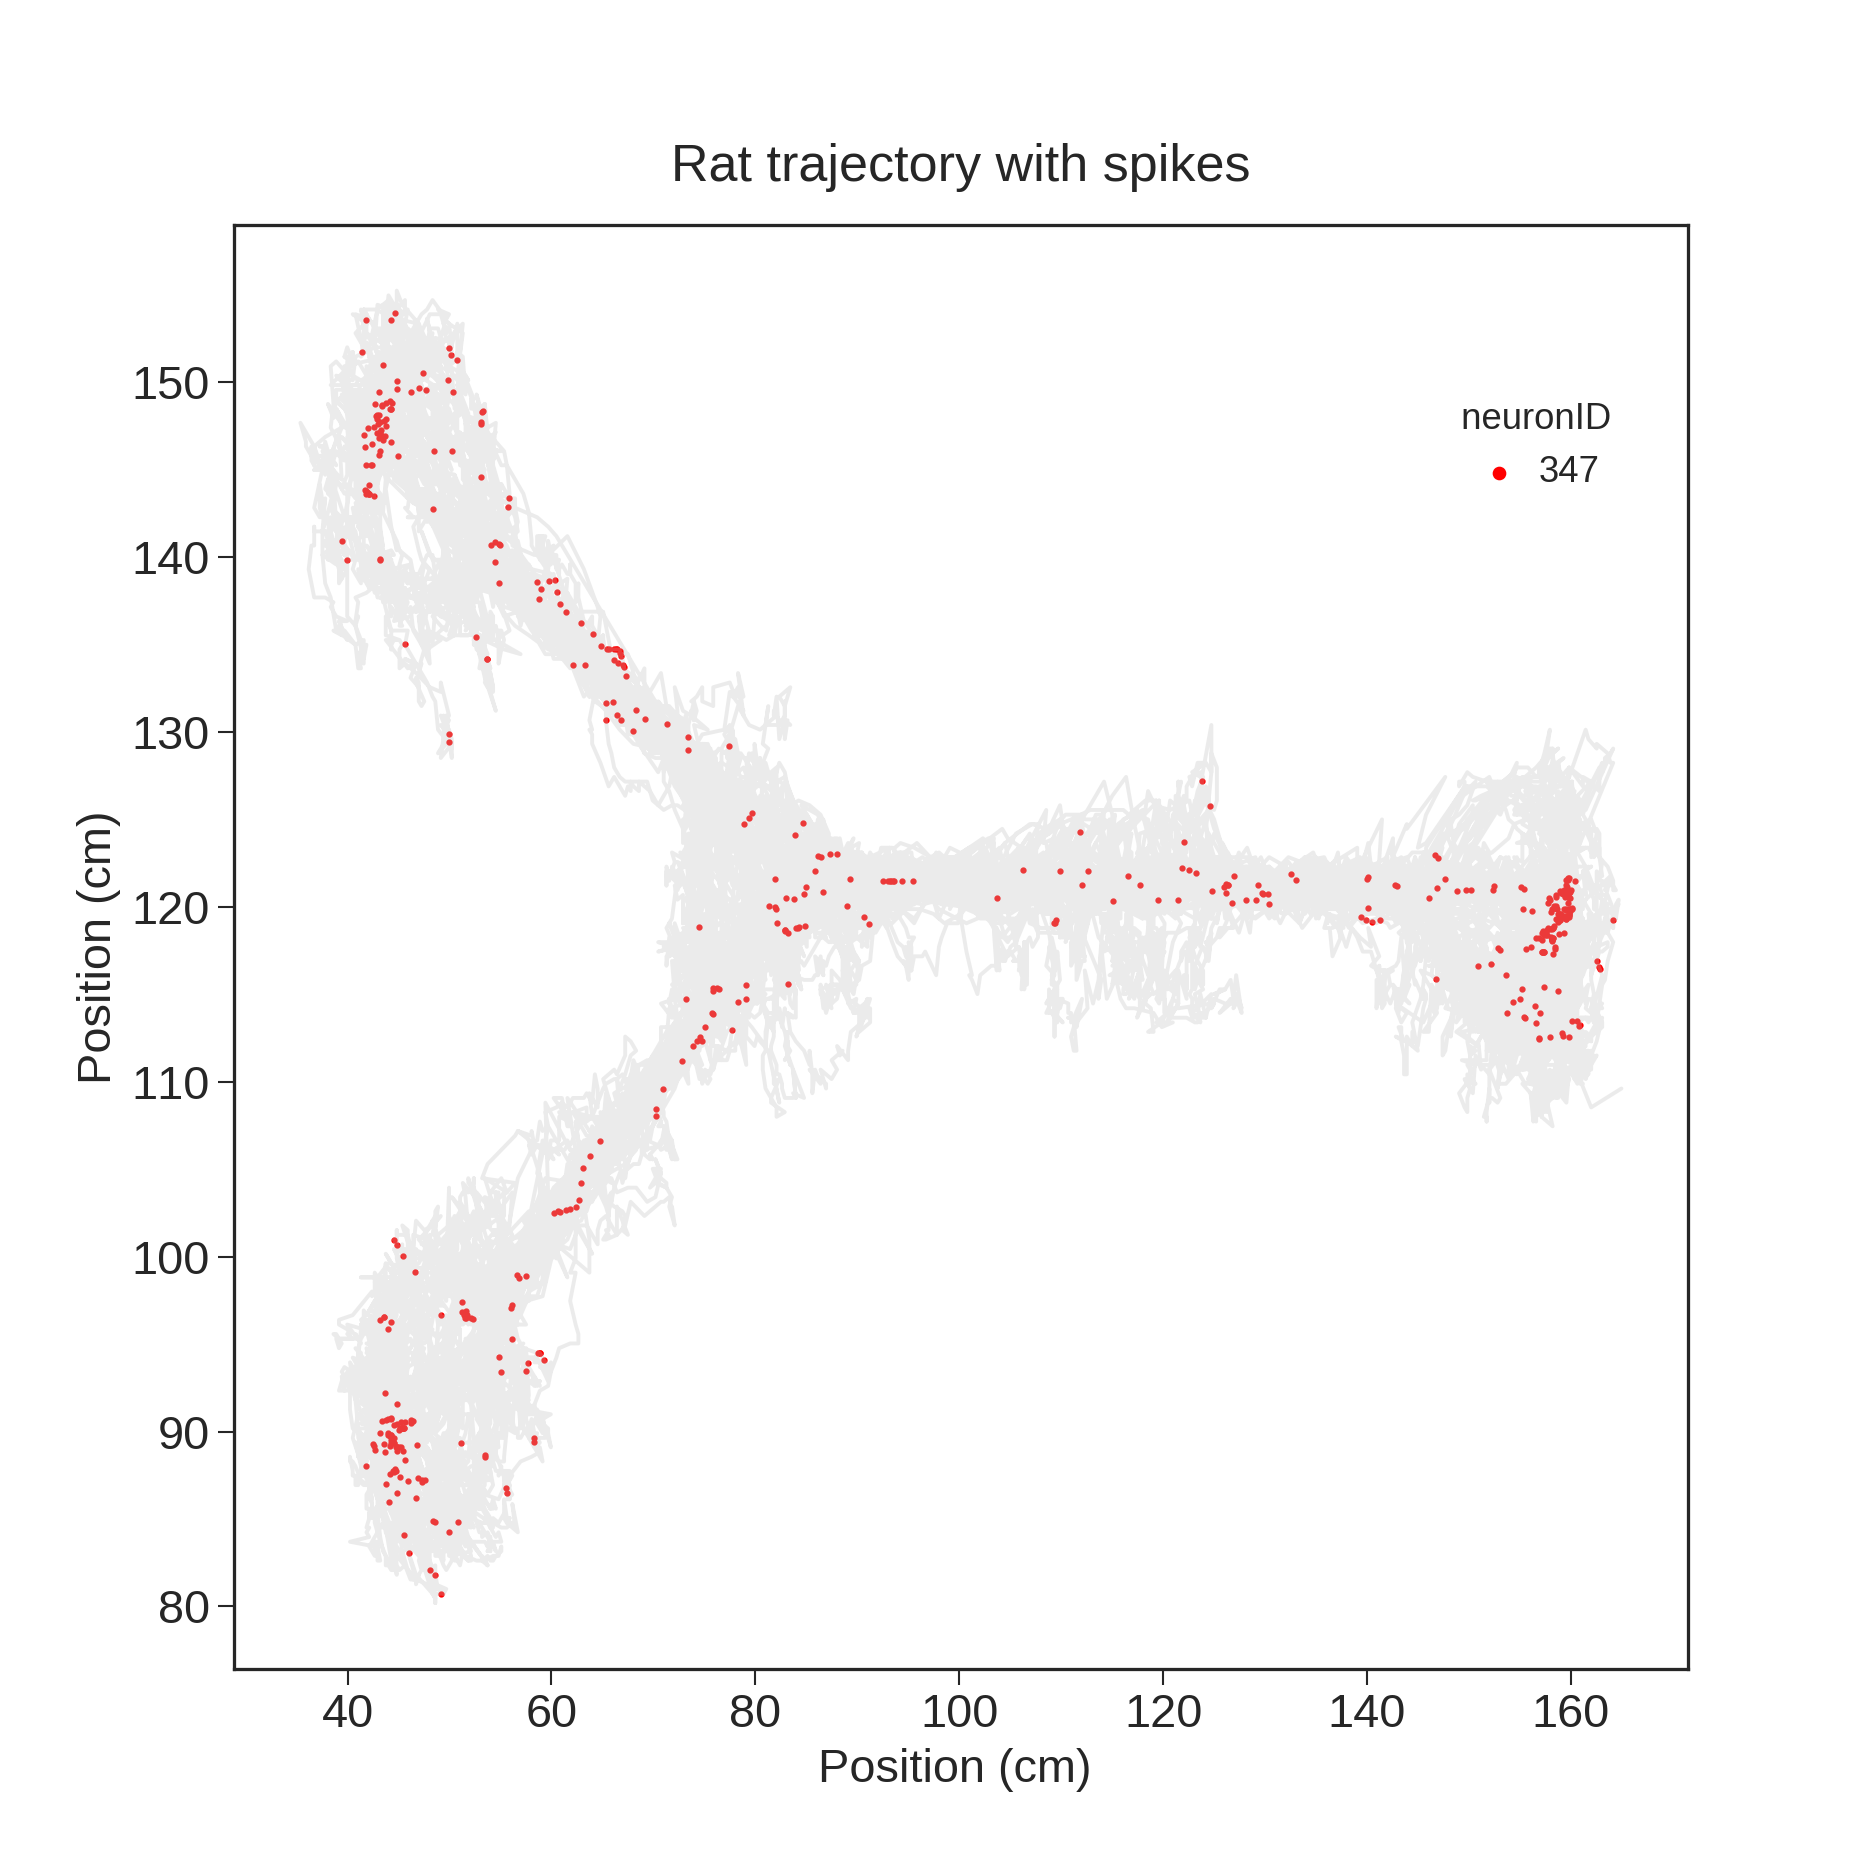

In [22]:
from scipy.interpolate import interp1d

spike_time_range_at = np.array(Y_maze_epoch) - loading.evt_start_time[1] + time_shift

plt.rcParams["figure.figsize"] = (10,10)

ks_spike_times = loading.ks_spike_times[:, 0] 
spike_t_347 = ks_spike_times[loading.get_spike_seq(spike_time_range_at, channel_list=[289])] + loading.evt_start_time[1]
# # spike_t_41 = ks_spike_times[loading.get_spike_seq(spike_time_range, channel_list=[41])]  + loading.evt_start_time
# print(spike_t_347)
# print('len(spike_t)=', len(spike_t))
# print('spike_t.min, max=', spike_t.min(0), spike_t.max(0))


t_at = corrected_time[np.logical_and(corrected_time > Y_maze_epoch[0], corrected_time < Y_maze_epoch[1])]
# t_lt = corrected_time[np.logical_and(corrected_time > linear_track_epoch[0], corrected_time < linear_track_epoch[1])]
mask = ~np.logical_or.reduce((
    np.isnan(t_at),
    np.isnan(position_at_cm[:, 0]),
    np.isnan(position_at_cm[:, 1]),
))
# mask = ~np.logical_or.reduce((
#     np.isnan(t_lt),
#     np.isnan(position_lt_cm[:, 0]),
#     np.isnan(position_lt_cm[:, 1]),
# ))

# print('   t_ob.min, max=', t_of[mask].min(), t_of[mask].max())
plt.plot(position_at_cm[mask, 0], position_at_cm[mask, 1], color="silver", alpha=0.3)
# plt.plot(position_lt_cm[mask, 0], position_lt_cm[mask, 1], color="silver", alpha=0.3)

interp1d_at = interp1d(t_at[mask], position_at_cm[mask, :],
                      axis=0, 
#                     fill_value='extrapolate', 
                    bounds_error=False,
                    assume_sorted=True)
# interp1d_od = interp1d(t_lt[mask], position_lt_cm[mask, :],
#                       axis=0, 
# #                     fill_value='extrapolate', 
#                     bounds_error=False,
#                     assume_sorted=True)


spike_xy_347 = interp1d_at(spike_t_347)
# spike_xy_41 = interp1d_od(spike_t_41)


plt.scatter(spike_xy_347[:, 0], spike_xy_347[:, 1], s=2, color='r', label='347')
# plt.scatter(spike_xy_41[:, 0], 100 - spike_xy_41[:, 1], s=2, color='g', label='41')

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.xlabel("Position (cm) ")
plt.ylabel("Position (cm)")
plt.title("Rat trajectory with spikes", y=1.02)
plt.legend(bbox_to_anchor=(0.97, 0.9), markerscale=3, handletextpad=0.1, title=' neuronID')
plt.rc('axes', labelsize=MEDIUM_SIZE)
# plt.savefig("rat_trajectory (open field)41.png")

plt.show()

In [31]:
# spike_t_34
print(spike_time_range_at)
print(spike_t_347)
print(t_at)

[1205.681976 2902.681976]
[3545.64755733 3546.204224   3550.47429067 3551.190124   3551.79819067
 3560.08475733 3565.35369067 3594.05955733 3601.39555733 3604.83765733
 3605.731724   3605.73989067 3630.761924   3651.75165733 3651.76169067
 3662.94745733 3663.155324   3670.628024   3674.17535733 3684.946124
 3689.68445733 3691.862024   3721.333924   3732.08679067 3732.15279067
 3737.72215733 3738.02349067 3747.55295733 3747.59595733 3749.05259067
 3761.999924   3764.35149067 3768.43209067 3784.22059067 3786.477024
 3786.48429067 3791.888124   3794.519424   3794.560424   3794.58315733
 3794.586224   3798.23015733 3803.688724   3804.10775733 3804.264624
 3812.99215733 3814.98379067 3814.98825733 3826.248124   3826.27435733
 3831.287624   3836.462824   3836.553624   3836.62649067 3849.25379067
 3849.258924   3849.394424   3881.46415733 3883.751524   3886.665824
 3886.86325733 3890.57139067 3892.81925733 3892.84295733 3892.861224
 3892.97879067 3893.34549067 3910.166324   3910.216924   3914

In [17]:
#open box

cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')
# print(cluster_channel['cluster'])
spike_t = {}
spike_time_range = np.array(open_field_epoch) - open_field_epoch[0] + time_shift


for cl in cluster_channel['cluster']:
    spike_ts = loading.ks_spike_times[np.logical_and.reduce((
        loading.ks_spike_clusters == cl,
        spike_time_range[0] <= loading.ks_spike_times[:, 0],
        loading.ks_spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t[cl] = spike_ts

    
# print(len(spike_t))



    x = position_ob_cm[:, 0]
    y = position_ob_cm[:, 1]
    mask = ~np.logical_or(np.isnan(x), np.isnan(y))

    spike_times_binned = scipy.stats.binned_statistic(spike_ts,
                                                  np.ones_like(spike_ts),
                                                  statistic='sum',
                                                  bins=len(x))[0]

# plt.plot(spike_times_binned)

    spike_bin = scipy.stats.binned_statistic_2d(y[mask], 
                                            x[mask], 
                                            spike_times_binned[mask], 
                                            statistic='mean', 
                                            bins=50)[0]

    spike_bin[np.isnan(spike_bin)] = 0.0
    spike_bin[np.isinf(spike_bin)] = 0.0


    plt.imshow(spike_bin, cmap='jet', origin='lower', extent=extent)
    
    spike_fr = {}
for
    ...
    spike_bin = scipy.stats.binned_statistic_2d(y[mask],
                                            x[mask],
                                            spike_times_binned[mask],
                                            statistic='mean',
                                            bins=50)[0]
    spike_bin[np.isnan(spike_bin)] = 0.0
    spike_bin[np.isinf(spike_bin)] = 0.0
    spike_fr[cl] = spike_bin
plt.imshow(spike_fr, cmap='jet', origin='lower', extent=extent)
# plt.xlim(70, 140)
# plt.ylim(9, 85)
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('Hz', rotation=270, fontsize=20, verticalalignment="bottom")
# plt.xlabel("Position (cm) ")
# plt.ylabel("Position (cm)")
# plt.title("Average firing rate (Hz) Neuron ID: 9", y=1.02)
# # plt.legend(bbox_to_anchor=(0.97, 0.9), markerscale=3, handletextpad=0.1, title=' neuronID')
# plt.rc('axes', labelsize=MEDIUM_SIZE)
# plt.savefig("firing_rate(open field)LS_K_5_140320_cl9.png")
# plt.show()

SyntaxError: invalid syntax (<ipython-input-17-7279b4c883ef>, line 47)

In [18]:
cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')
# print(cluster_channel['cluster'])
    
x = position_at_cm[:, 0]
y = position_at_cm[:, 1]
mask = ~np.logical_or(np.isnan(x), np.isnan(y))
spike_time_range = np.array(open_field_epoch) - open_field_epoch[0] + time_shift
spike_fr_step = 10.0
spike_bins = int((spike_time_range[1] - spike_time_range[0]) / spike_fr_step) + 1
spike_t = {}
spike_fr = {}
rm = {}
for cl in cluster_channel['cluster']:
    spike_ts = loading.ks_spike_times[np.logical_and.reduce((
        loading.ks_spike_clusters == cl,
        spike_time_range[0] <= loading.ks_spike_times[:, 0],
        loading.ks_spike_times[:, 0] <= spike_time_range[1]
    )), 0]
        
    spike_t[cl] = spike_ts

    if len(spike_ts):
        binned = scipy.stats.binned_statistic(spike_ts, 
                                          np.ones_like(spike_ts),
                                          statistic='count', 
                                          bins=spike_bins)[0] / spike_fr_step
    else:
        binned = np.zeros((spike_bins,))
    

#     print(binned)
    pos_bin = scipy.stats.binned_statistic_2d(x[mask], 
                                          y[mask], 
                                          np.ones_like(x), 
                                          statistic='count', 
                                          bins=spike_bins)[0] / spike_fr_step 

 
    print(pos_bin)
    spike_fr[cl] = binned
    rm[cl] = [binned / pos_bin for cl in cluster_channel['cluster']]
    
spike_fr_array =  np.array([spike_fr[cl] for cl in cluster_channel['cluster']])
rm_array =  np.array([rm[cl] for cl in cluster_channel['cluster']])
# plt.imshow(spike_fr_array, cmap='jet')
plt.imshow(rm_array[2] , cmap='jet')


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

/home/kasia/miniconda3/envs/fklab/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/kasia/miniconda3/envs/fklab/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

<IPython.core.display.Javascript object>

TypeError: Invalid shape (88, 119, 119) for image data

In [59]:
rm[cl]

[array([[inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        ...,
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf]]),
 array([[inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        ...,
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf]]),
 array([[inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        ...,
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf]]),
 array([[inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        [inf, inf, inf, ..., nan, nan, inf],
        ..

In [19]:
spike_fr_array[1]

array([2.3, 1. , 2.7, 1.6, 1.6, 1.9, 1.8, 2.2, 1.9, 1.2, 2. , 1.6, 2.2,
       0.7, 2. , 0.7, 1.8, 1.3, 1.9, 1.4, 2.1, 1.7, 1.5, 1.6, 1.8, 1.8,
       1.8, 2. , 1.7, 1.6, 2.2, 1.1, 1.4, 1.3, 1.6, 1.7, 1.8, 1.4, 1.5,
       1.3, 1.6, 1.9, 1.7, 1.1, 1.6, 1.3, 1. , 1.2, 1.2, 1.7, 1.5, 1.6,
       0.7, 1.5, 0.4, 1.3, 1.2, 1.2, 1.6, 1.8, 1.2, 2. , 1.9, 0.9, 1.8,
       1.6, 1.9, 1.9, 2.5, 2.6, 1.4, 1.1, 1.1, 1.5, 1.5, 0.8, 2. , 1.3,
       1.2, 1. , 2.4, 0.7, 1.5, 1.2, 1. , 1.4, 1.9, 2. , 2.3, 1. , 1.6,
       1.8, 2. , 1. , 1.6, 0.9, 1.9, 1.2, 0.9, 2.1, 1. , 1.8, 0.9, 1.3,
       1.8, 1.4, 1.7, 1.4, 0.7, 1.8, 1.6, 1.7, 1.2, 1.1, 1.9, 1.2, 1.4,
       1.4, 1.3])

In [23]:
from fklab.signals.smooth import create_smoother
import fklab.ratemap as rm
from fklab.plot.plots import plot_2d_maps

cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')

spike_time_range = np.array(open_field_epoch) - loading.evt_start_time[1] + time_shift
ks_spike_times = loading.ks_spike_times[:, 0] 
spike_x = ks_spike_times[loading.get_spike_seq(spike_time_range, channel_list=[26])] + loading.evt_start_time[1]

t_of = corrected_time[np.logical_and(corrected_time > open_field_epoch[0], corrected_time < open_field_epoch[1])]

x = position_ob_cm[:, 0]
y = position_ob_cm[:, 1]

stackxy = np.column_stack([x,y])
eventxy = [rm.compute_variable_at_times(z, variable=stackxy, var_t=t_of)
           for z in [spike_x]]


# print(eventxy)
# print(stackxy)

# rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
#     *eventxy,
#     stimdata = stackxy,
#     stimduration=1/50,
#     smooth = 2,
#     bins = 50)
   
rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
    *eventxy,
    stimdata = stackxy,
    stimduration=1/40,
#     smooth = 5,
#     valid = in_circle(50),
    bins = [np.linspace(70,134,50), np.linspace(9,81,50)])

# fig, axes = plot_2d_maps(
#     [*rmap_hist,occ_hist],
#     coordinates=binedges,
#     cmap='inferno',
#      xlabel="x [cm]",
#      ylabel="y [cm]",
#     colorlabel="firing rate [Hz] / occupancy [s]",
#     cbar=True,
#     grid=(None,2),
#     figsize=(14,4),
#     cmin=0, cmax='auto',
#     roundto=.5
# )


# axes[0,0].set(title='place cell')
# # axes[0,1].set(title='heading cell')
# axes[0,1].set(title='occupancy');

# for ax in axes.ravel():
#     ax.set_frame_on(False)
#     ax.axis('equal')

# plt.savefig("rate map.png")
# print(occ_hist)
# print(binedges)


<IPython.core.display.Javascript object>


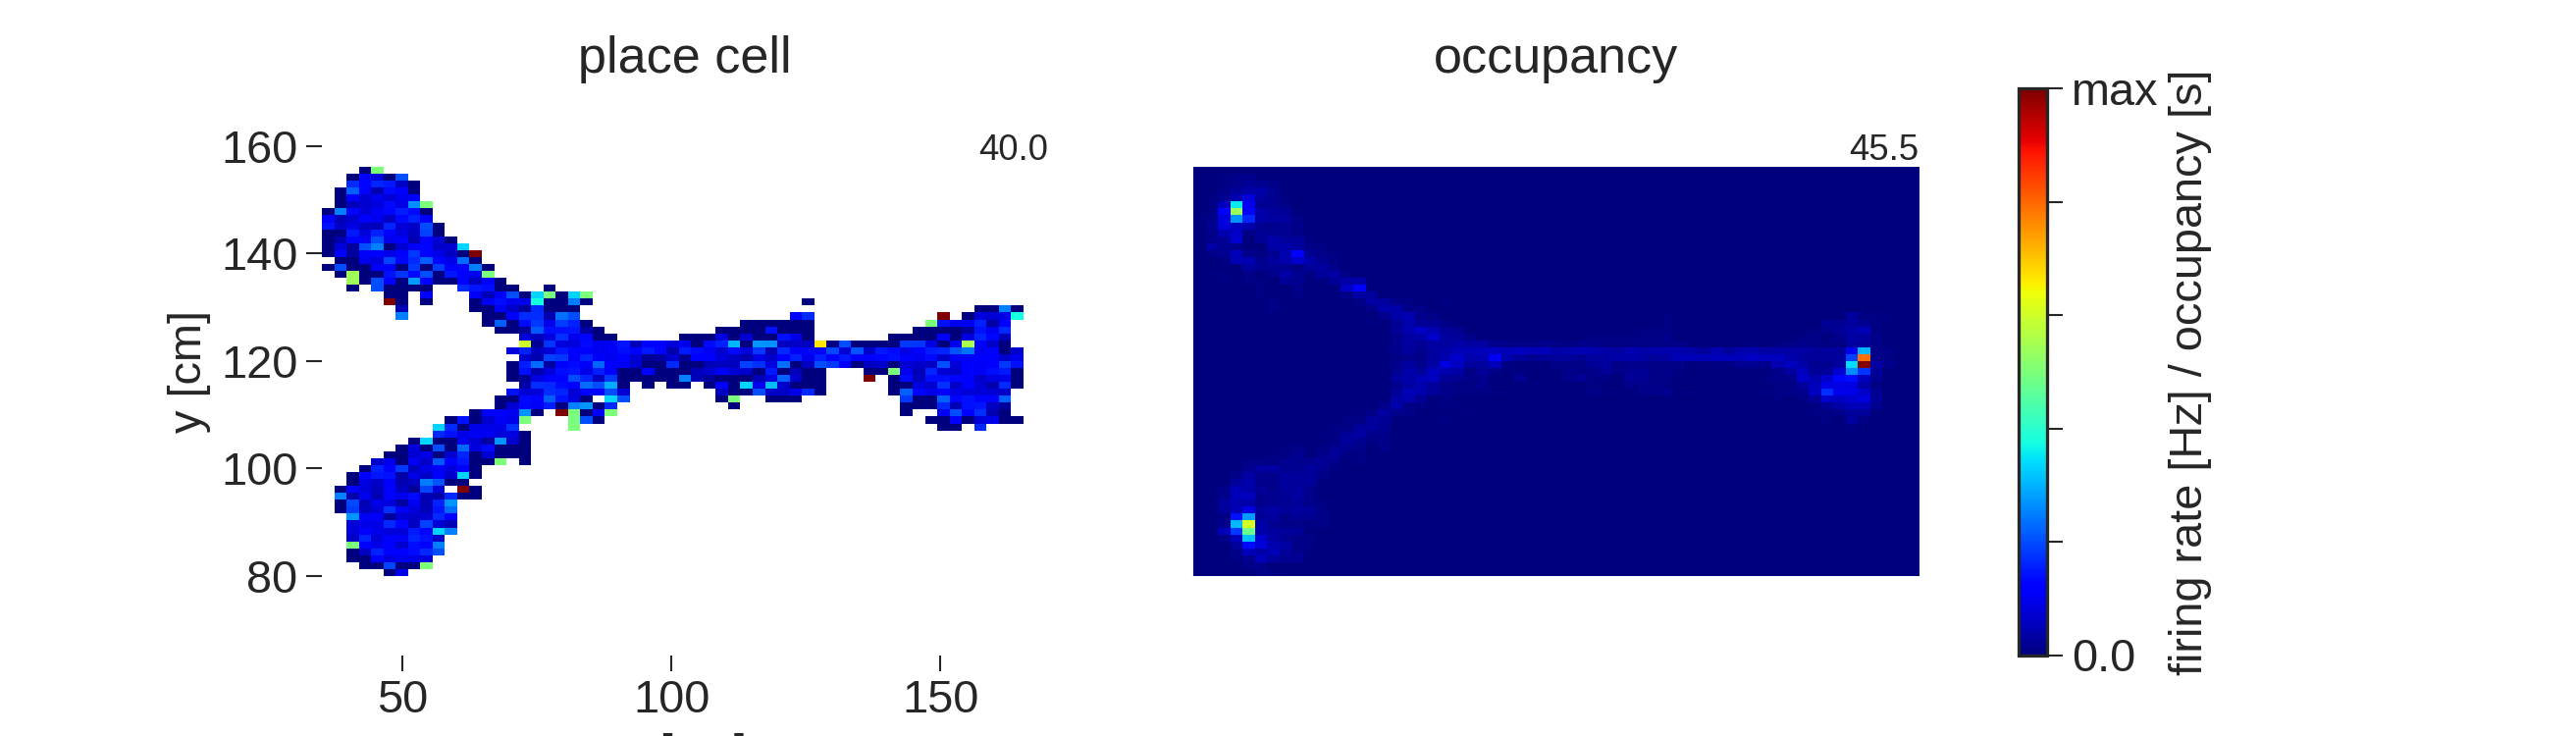

In [25]:
from fklab.signals.smooth import create_smoother
import fklab.ratemap as rm
from fklab.plot.plots import plot_2d_maps

cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')

spike_time_rangeat = np.array(Y_maze_epoch) - loading.evt_start_time[1] + time_shift

ks_spike_times = loading.ks_spike_times[:, 0] 

spike_xat = ks_spike_times[loading.get_spike_seq(spike_time_rangeat, cluster_list=[20])] + loading.evt_start_time[1]

t_at = corrected_time[np.logical_and(corrected_time > Y_maze_epoch[0], corrected_time < Y_maze_epoch[1])]
position_at = loading.position[np.logical_and(corrected_time > Y_maze_epoch[0],
                                      corrected_time < Y_maze_epoch[1]), :]
position_at_cm = position_at * 0.27
xat = position_at_cm[:, 0]
yat = position_at_cm[:, 1]

stackxyat = np.column_stack([xat,yat])
eventxyat = [rm.compute_variable_at_times(z, variable=stackxyat, var_t=t_at)
           for z in [spike_xat]]


# print(eventxy)
# print(stackxy)

# rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
#     *eventxy,
#     stimdata = stackxy,
#     stimduration=1/50,
#     smooth = 2,
#     bins = 50)
   
rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
    *eventxyat,
    stimdata = stackxyat,
    stimduration=1/40,
#     smooth = 5,
#     valid = in_circle(50),
    bins = [np.linspace(35,170,60), np.linspace(80,156,60)])

fig, axes = plot_2d_maps(
    [*rmap_hist,occ_hist],
    coordinates=binedges,
    cmap='jet',
     xlabel="x [cm]",
     ylabel="y [cm]",
    colorlabel="firing rate [Hz] / occupancy [s]",
    cbar=True,
    grid=(None,2),
    figsize=(14,4),
    cmin=0, cmax='auto',
    roundto=.5
)


axes[0,0].set(title='place cell')
# axes[0,1].set(title='heading cell')
axes[0,1].set(title='occupancy');

for ax in axes.ravel():
    ax.set_frame_on(False)
    ax.axis('equal')

# plt.savefig("rate map.png")
# print(occ_hist)
# print(binedges)


In [293]:
# print(spike_xat)
# print(t_at)
# print(ks_spike_times)
# print(eventxyat)
print(rmap_hist)
# print(occ_hist)

[array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.        , ..., 6.66666667, 0.        ,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])]


<IPython.core.display.Javascript object>


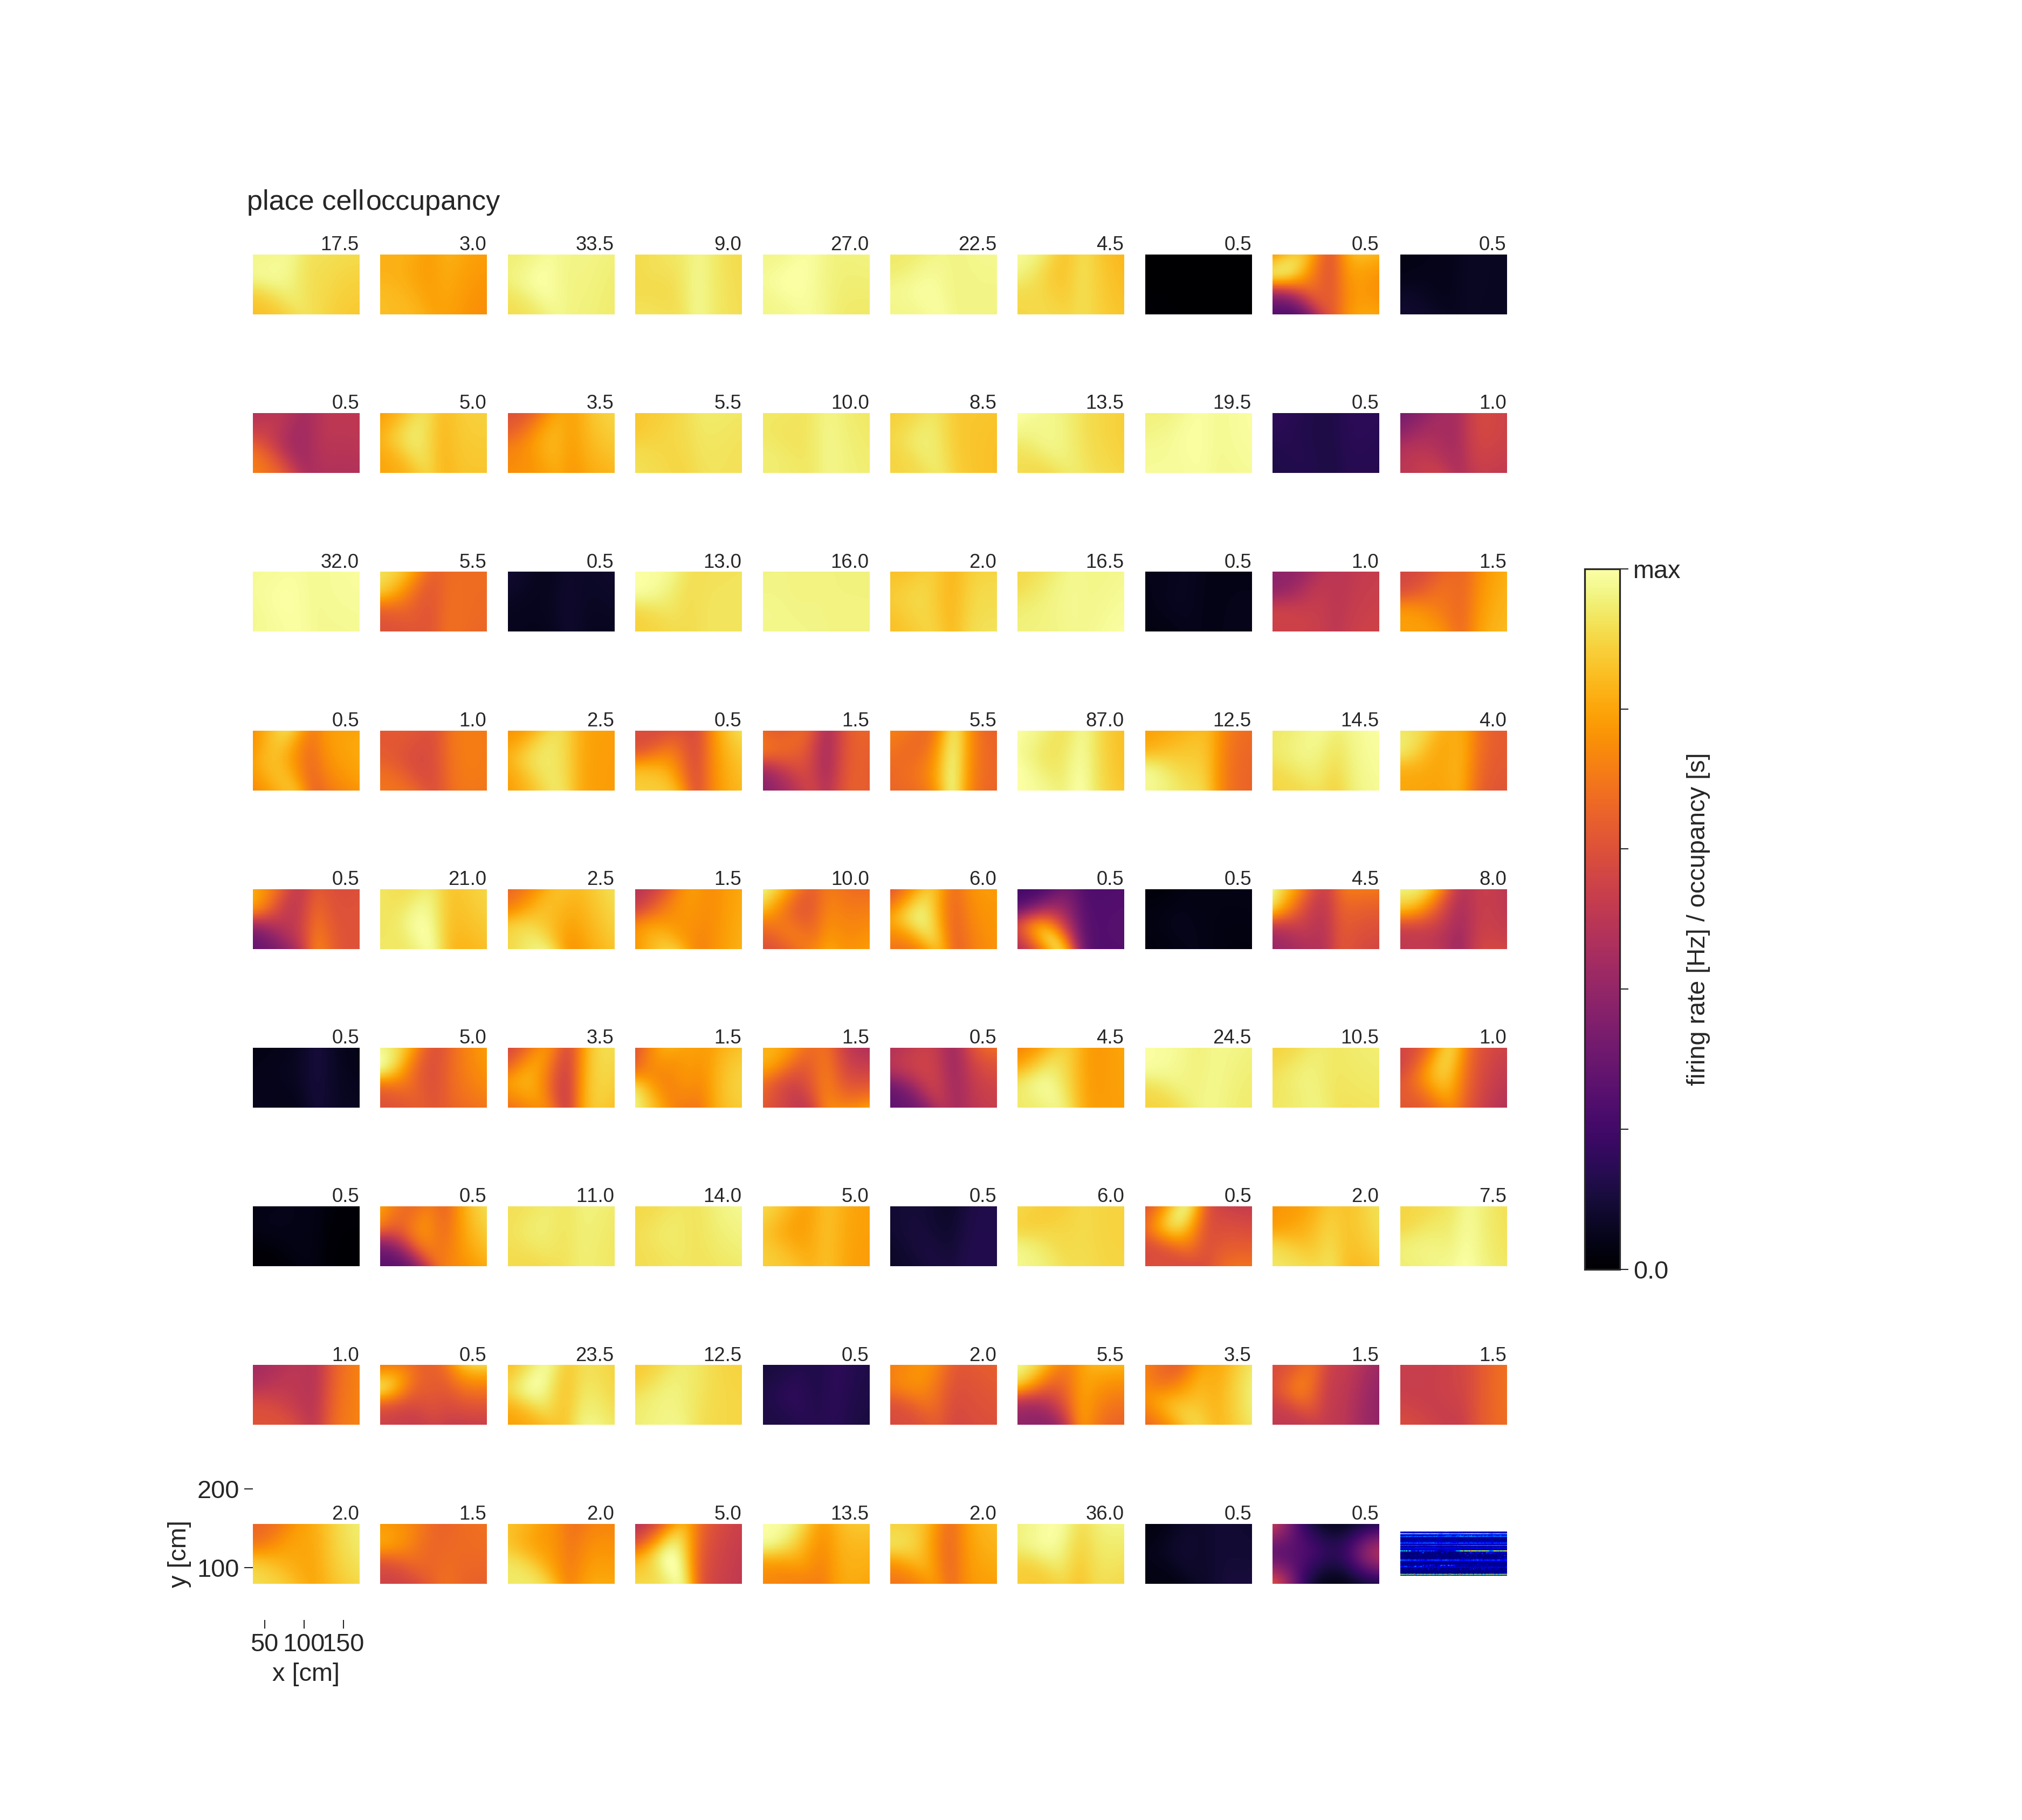

In [46]:
from os import path
outpath = '/media/kasia/K/Neuropixeldata/LS_k_5/14_03_20_plots'
cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')
spike_t = {}
for cl in cluster_channel['cluster']:
    spike_xat = ks_spike_times[loading.get_spike_seq(spike_time_rangeat, cluster_list=[cl] )] + loading.evt_start_time[1]

    spike_t[cl]=spike_xat

t_at = corrected_time[np.logical_and(corrected_time > Y_maze_epoch[0], corrected_time < Y_maze_epoch[1])]
event = {key: rm.compute_variable_at_times(z, variable=position_at_cm, var_t=t_at) for key, z in spike_t.items()}

eventat = list(event.values())
for i in eventat:
    rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
        *eventat,
        stimdata = position_at_cm,
        stimduration=1/40,
        smooth=20,
        bins = [np.linspace(35,170,100), np.linspace(80,156,100)])
    
# rmap_hist1 = np.array(rmap_hist)   
# occ_hist1 = np.array(occ_hist)

# for i, j in zip(rmap_hist1, occ_hist1):
#     fig, axes = plot_2d_maps(
#         [*rmap_hist1,occ_hist1],
#         coordinates=binedges,
#         cmap='inferno',
#         xlabel="x [cm]",
#         ylabel="y [cm]",
#         colorlabel="firing rate [Hz] / occupancy [s]",
#         cbar=True,
#         grid=(None,2),
#         figsize=(14,3.5),
#         cmin=0, cmax='auto',
#         roundto=.5
#         )
    
#     axes[0,0].set(title='place cell')
#     axes[0,1].set(title='occupancy');

#     for ax in axes.ravel():
#         ax.set_frame_on(False)
#         ax.axis('equal')
 
#     plt.savefig("ATfiringrate.png")

fig, axes = plot_2d_maps(
        [*rmap_hist,occ_hist],
        coordinates=binedges,
        cmap='inferno',
        xlabel="x [cm]",
        ylabel="y [cm]",
        colorlabel="firing rate [Hz] / occupancy [s]",
        cbar=True,
        grid=(None),
#         figsize=(14,3.5),
        axsize=(2,2),
        cmin=0, cmax='auto',
        roundto=.5,
        cbar_kw=dict(shrink=0.5)
        )
    
axes[0,0].set(title='place cell')
axes[0,1].set(title='occupancy');

for ax in axes.ravel():
        ax.set_frame_on(False)
        ax.axis('equal')

plt.savefig("ATratemap140320.png")

In [44]:
print(cmax)

NameError: name 'cmax' is not defined

In [45]:
# print(eventxy)
# print([type(x) for x in spike_t])
# print([len(x) for x in spike_t.values()]) 

# print([(np.min(x), np.max(x)) if len(x)>0 else (None, None) for x in spike_t.values()])

# print(np.min(t_at), np.max(t_at))
# print(spike_time_range)
# print(loading.evt_start_time[1])
# print(spike_time_range)
# print(t_at)
# print(spike_t[2])
# print(Y_maze_epoch)
# print(spike_t[2])
# print(spike_t[20])
# print(len(eventatar))
# print(event)
# print([type(x) for x in occ_hist])
# print(len(eventatar))
# print(binedges)
# print(rmap_hist[0])
print(occ_hist)

[[ 1.80355046e-01  2.01188992e-01  2.23318462e-01 ...  3.12738518e-01
   2.84503680e-01  2.57460220e-01]
 [ 2.36897016e-01  2.63726613e-01  2.92165135e-01 ...  3.75253568e-01
   3.41900348e-01  3.09876458e-01]
 [ 3.03424107e-01  3.37028481e-01  3.72568859e-01 ...  4.39622146e-01
   4.01165120e-01  3.64157290e-01]
 ...
 [ 5.59836304e-17  2.95593303e-18  3.76605705e-17 ... -9.68414669e-17
  -1.06413589e-16 -1.05380951e-16]
 [ 1.03442679e-16  1.24081451e-16  1.19833541e-16 ... -6.14530981e-17
  -2.70109280e-17 -3.00924156e-17]
 [ 1.85622405e-16  1.68621925e-16  1.26051528e-16 ... -9.49953547e-17
  -1.60592310e-16 -1.78913162e-16]]


In [262]:
from fklab.signals.smooth import create_smoother
import fklab.ratemap as rm
from fklab.plot.plots import plot_2d_maps

cluster_channel = pd.read_csv('/media/kasia/K/Neuropixeldata/data_analysis/Cluster_channel_LS_K_5_140320.tsv', sep='\t')

for cl in cluster_channel['cluster']:
    spike_time_rangeat = np.array(Y_maze_epoch) - loading.evt_start_time[1] + time_shift
    spike_xat = loading.ks_spike_times[np.logical_and.reduce((
        loading.ks_spike_clusters == cl,
        spike_time_range[0] <= loading.ks_spike_times[:, 0],
        loading.ks_spike_times[:, 0] <= spike_time_range[1]
    )), 0]
    print(spike_xat)
    t_at = corrected_time[np.logical_and(corrected_time > Y_maze_epoch[0], corrected_time < Y_maze_epoch[1])]

    xat = position_at_cm[:, 0]
    yat = position_at_cm[:, 1]

    stackxyat = np.column_stack([xat,yat])
    eventxyat = [rm.compute_variable_at_times(z, variable=stackxyat, var_t=t_at)
                 for z in [spike_xat]]
    
    print(eventxyat)
    print(spike_xat.shape)
   
#     rmap_hist, _, occ_hist, binedges = rm.hist.ratemap(
#         *eventxyat,
#         stimdata = stackxyat,
#         stimduration=1/40,
#         bins = [np.linspace(35,170,60), np.linspace(80,156,60)])

#     fig, axes = plot_2d_maps(
#         [*rmap_hist,occ_hist],
#         coordinates=binedges,
#         cmap='jet',
#          xlabel="x [cm]",
#          ylabel="y [cm]",
#         colorlabel="firing rate [Hz] / occupancy [s]",
#         cbar=True,
#         grid=(None,2),
#         figsize=(14,4),
#         cmin=0, cmax='auto',
#         roundto=.5
#     )


#     axes[0,0].set(title='place cell')
#     # axes[0,1].set(title='heading cell')
#     axes[0,1].set(title='occupancy');

#     for ax in axes.ravel():
#         ax.set_frame_on(False)
#         ax.axis('equal')
        
#     plt.savefig('firing_rate_AT{cl}.png'.format(cl=cl))

[1205.76366667 1205.93583333 1206.04366667 ... 2902.42046667 2902.426
 2902.52166667]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85]])]
(17033,)
[1207.36343333 1208.3485     1208.8216     ... 2902.24396667 2902.2715
 2902.58913333]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85]])]
(2570,)
[1205.71186667 1205.76656667 1205.82426667 ... 2902.5049     2902.55823333
 2902.66383333]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85]])]
(33923,)
[1205.70006667 1205.7125     1205.71916667 ... 2901.94086667 2902.0765
 2902.08066667]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71,

[1205.71353333 1205.79746667 1205.82013333 ... 2902.23116667 2902.31353333
 2902.53186667]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85]])]
(13345,)
[1205.68953333 1205.8503     1205.975      ... 2902.32443333 2902.48353333
 2902.55623333]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85]])]
(20277,)
[1211.74076667 1218.5509     1249.0166     1252.48603333 1291.19596667
 1291.4143     1373.7613     1431.01773333 1443.5715     1456.7219
 1482.0323     1487.00786667 1490.0496     1495.81843333 1537.4073
 1603.0374     1612.1481     1615.22196667 1672.89686667 1690.2427
 1701.84406667 1712.31383333 1748.4116     1755.97953333 1805.33523333
 1807.99693333 1809.66336667 1814.10986667 1830.1836     1884.21666667
 1908.38243333 1910.064      1930.19076667 1949.05923333

[1208.00946667 1218.15496667 1221.34723333 1222.56573333 1223.92486667
 1227.5321     1229.4615     1229.56386667 1229.8865     1233.56
 1233.73593333 1233.83383333 1233.92993333 1234.04426667 1234.79513333
 1256.18966667 1256.5748     1256.75543333 1257.9515     1260.68833333
 1287.79136667 1289.37103333 1294.03776667 1298.944      1301.53373333
 1303.3744     1304.0995     1306.1273     1311.2132     1314.6551
 1319.7179     1321.56766667 1327.84743333 1333.34306667 1335.14006667
 1340.6623     1341.12816667 1341.2499     1342.70746667 1347.26866667
 1352.39233333 1360.3911     1363.90996667 1364.676      1367.10856667
 1368.0677     1368.6597     1377.02226667 1386.02763333 1388.23386667
 1389.3752     1390.3587     1393.2239     1398.3067     1402.85086667
 1421.4365     1421.75793333 1423.17756667 1423.81696667 1427.5937
 1427.93353333 1429.14883333 1431.13666667 1431.14226667 1432.78013333
 1444.48183333 1450.08616667 1455.18486667 1455.22256667 1455.38806667
 1457.24963333 1458.

[1218.11756667 1234.5169     1508.1381     1669.97186667 1724.70553333
 1857.74396667 1901.77366667 1977.2053     2018.0671     2037.6048
 2051.13663333 2053.50066667 2053.50946667 2053.5155     2053.54476667
 2053.55496667 2053.5826     2053.6402     2053.65463333 2053.69433333
 2053.7397     2053.78173333 2053.83996667 2053.85323333 2053.914
 2053.9781     2054.0041     2054.02083333 2054.04013333 2054.0917
 2054.09853333 2054.15226667 2054.163      2054.18726667 2054.19783333
 2054.2402     2054.2499     2054.27283333 2054.28153333 2054.28866667
 2054.30386667 2054.32296667 2054.33616667 2054.35223333 2054.36023333
 2054.39463333 2054.4105     2054.4258     2054.44993333 2054.4675
 2054.5305     2054.59003333 2054.612      2054.63023333 2054.66006667
 2054.6716     2054.6908     2054.71773333 2054.73433333 2054.80256667
 2054.8266     2054.84243333 2054.87586667 2054.91506667 2054.93766667
 2054.97163333 2055.06563333 2055.08076667 2055.12333333 2055.1454
 2055.25983333 2055.2937333

[1206.18576667 1206.20483333 1206.2685     ... 2901.9735     2902.3061
 2902.55136667]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85]])]
(10854,)
[1205.7088     1205.81646667 1205.92423333 ... 2902.28166667 2902.5805
 2902.66056667]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85]])]
(13836,)
[1207.36223333 1207.43693333 1209.36653333 ... 2899.8527     2900.92246667
 2901.4826    ]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85]])]
(4428,)
[1208.259      1238.1016     1268.17576667 1277.0782     1290.52256667
 1309.84266667 1339.90513333 1363.56963333 1381.0846     1386.98843333
 1421.4915     1569.1101     1603.44543333 1661.11103333 1687.48826667
 

[1225.08523333 1252.23963333 1264.05216667 ... 2895.69366667 2898.3301
 2899.2467    ]
[array([[ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       ...,
       [ 73.71, 122.85],
       [ 73.71, 122.85],
       [ 73.71, 122.85]])]
(2967,)
[1207.91786667 1208.04486667 1209.8292     1209.96033333 1210.25836667
 1211.39293333 1212.90743333 1212.97323333 1213.0551     1214.2082
 1214.26286667 1214.85026667 1216.63873333 1218.4244     1220.10226667
 1221.12876667 1223.36056667 1223.55146667 1228.24316667 1237.01946667
 1238.0831     1245.9546     1250.79353333 1253.0724     1253.93086667
 1256.64003333 1257.07113333 1258.56043333 1262.77346667 1263.284
 1263.95926667 1264.4603     1265.63706667 1265.74213333 1265.89616667
 1266.03423333 1266.15453333 1266.29106667 1266.314      1266.4622
 1266.5172     1266.63176667 1266.66066667 1266.72153333 1266.94683333
 1266.9646     1267.0138     1267.04383333 1267.1807     1267.44863333
 1267.77023333 1267.95596667 1268.00593333 

In [ ]:
print(spike_xat.shape)

<IPython.core.display.Javascript object>


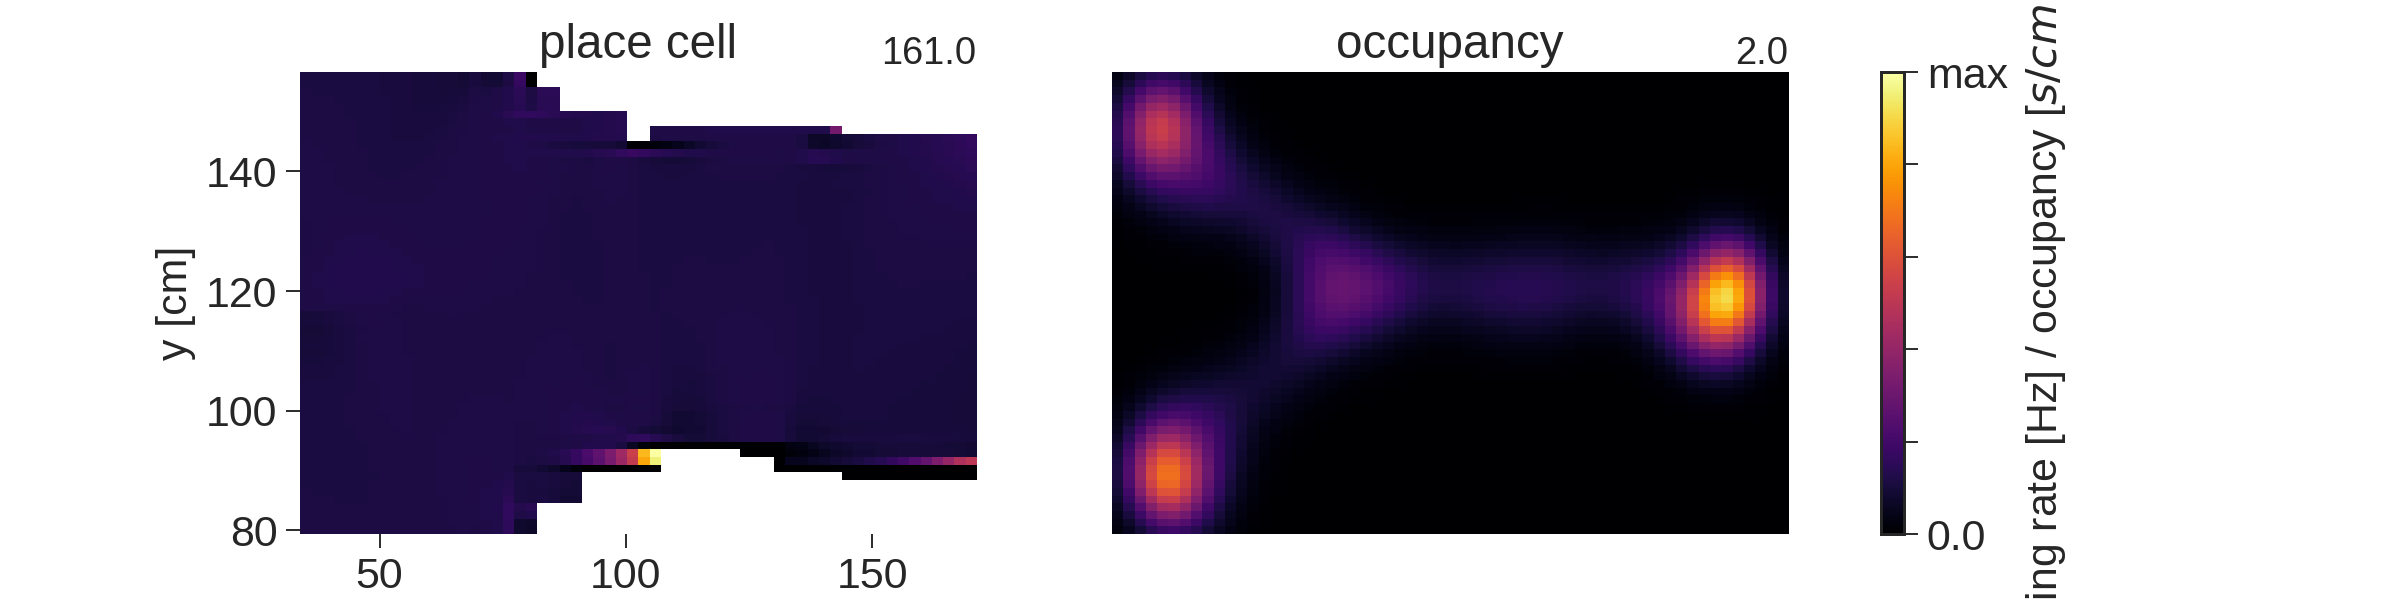

In [111]:

rmap, _, occ, samplegrid = rm.kde.linear_2d_tuning(
    spike_xat,
    xy = np.column_stack([xat,yat]),
    t = t_at,
    bandwidth = 5.,
    grid = [np.linspace(35,170,60), np.linspace(80,156,60)],
#     valid = in_circle(radius=50),
    compression=1.)

fig, axes = plot_2d_maps(
    [*rmap,occ],
    coordinates=samplegrid,
    cmap='inferno',
    xlabel="x [cm]",
    ylabel="y [cm]",
    colorlabel="firing rate [Hz] / occupancy [$s/cm^2$]",
    cbar=True,
    grid=(1,2),
    figsize=(14,3.5),
    cmin=0, cmax='auto',
    roundto=.5
)

axes[0,0].set(title='place cell')
# axes[0,1].set(title='heading cell')
axes[0,1].set(title='occupancy');

for ax in axes[0,:]:
    ax.set_frame_on(False)
    
plt.savefig("rate map den.png")